In [1]:
# !pip install tensorflow
#!pip install transformers
#!pip install tf-keras
# !pip install imblearn

In [1]:
import sys
from pathlib import Path

# Zum übergeordneten Ordner 'src' wechseln
current_path = Path().resolve()
src_path = current_path.parents[2]  # Zwei Stufen nach oben

if str(src_path) not in sys.path:
    sys.path.append(str(src_path))

src_path


WindowsPath('C:/Users/Nasiba/Documents/1 Master Data Science/Projektpraktikum/WebScience24')

In [2]:


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

from collections import Counter
#nlp = spacy.load("en_core_web_sm")
from nltk import word_tokenize
pd.set_option('display.max_colwidth', None)
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from vector_functions import vectorize_word2vec,  vectorize_glove_new,vectorize_glove, vectorize_glove_2, vectorize_glove_test_data, vectorize_glove_test_data_2, vectorize_word2vec_test_data, vectorize_glove_3, vectorize_glove_test_data_3, vectorize_fasttext_2, vectorize_fasttext_test_data
import nltk

import os
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional, Embedding
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Recall, Precision
from tensorflow.keras.callbacks import EarlyStopping

from tensorflow.keras.callbacks import ReduceLROnPlateau




ImportError: cannot import name 'vectorize_glove_new' from 'vector_functions' (c:\Users\Nasiba\Documents\1 Master Data Science\Projektpraktikum\WebScience24\src\3. Deep Learning Approach\nasiba\vector_functions.py)

#### Beladung der Daten

In [ ]:

source_filepath_name = os.path.abspath(os.path.join(src_path, 'data/mixed_dataset/train_cleaned_rnn.csv'))

df_cleaned = pd.read_csv(source_filepath_name, encoding='utf-8', index_col=0)

source_filepath_name_test = os.path.abspath(os.path.join(src_path, 'data/mixed_dataset/test_cleaned_rnn.csv'))

df_cleaned_test = pd.read_csv(source_filepath_name_test, encoding='utf-8', index_col=0)

X_new_train_data = df_cleaned['tweet_cleaned']
y_new_train_data = df_cleaned['label']

X_new_test_data = df_cleaned_test['tweet_cleaned']
y_new_test_data = df_cleaned_test['label']


df_cleaned.head(1)


label                                                           tweet  \
140232      0  Nicki's "that's not good" pout bought to you by Botox[™]. #MKR   

                                                              tweet_cleaned  \
140232  nickis "thats not good" pout bought to you by botox trade mark  mkr   

        user_handle  hashtags          emojis  
140232            0  ['#mkr']  __trade_mark__

In [19]:
def tokenize(X_data, y_data, tokenizer=None, max_len=40):
    X_data = [str(x) for x in X_data]

    # Wenn kein Tokenizer bereitgestellt wird, erstelle einen neuen
    if tokenizer is None:
        tokenizer = Tokenizer(oov_token="<OOV>")
        tokenizer.fit_on_texts(X_data)

    # Tokenisierung
    X_data_sequences = tokenizer.texts_to_sequences(X_data)
    X_data_padded_sequences = pad_sequences(X_data_sequences, padding='post', maxlen=max_len)
    return X_data_padded_sequences, y_data, tokenizer

def load_embeddings(file_path, embedding_dim, word_index):
    embedding_index = {}
    with open(file_path, encoding='utf-8') as f:
        for line in f:
            values = line.rstrip().split(' ')
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embedding_index[word] = coefs

    embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))
    for word, i in word_index.items():
        embedding_vector = embedding_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

    return embedding_matrix

def tokenize_and_split_data(X_train_data, y_train_data, X_test_data, y_test_data):
    X_gru, y_gru, tokenizer = tokenize(X_train_data, y_train_data)
    X_train_gru, X_val_gru, y_train_gru, y_val_gru = train_test_split(X_gru, y_gru, test_size=0.2, random_state=42)
    X_test_gru, y_test_gru, _ = tokenize(X_test_data, y_test_data, tokenizer)
    return X_train_gru, X_val_gru, y_train_gru, y_val_gru, X_test_gru, y_test_gru, tokenizer

twitter_glove_path = os.path.abspath(os.path.join(src_path, 'src/3. Deep Learning Approach/nasiba/glove.6B.200d.txt'))
X_train_token, X_val_token, y_train_token, y_val_token, X_test_token, y_test_token, tokenizer = tokenize_and_split_data(X_new_train_data, y_new_train_data, X_new_test_data, y_new_test_data)
glove_embedding_matrix = load_embeddings(twitter_glove_path, 200, tokenizer.word_index)

samples, vector_size = X_train_token.shape
num_classes = len(np.unique(y_train_token))

# Modellinitialisierung
model_21 = Sequential()

# Embedding Layer mit GloVe
model_21.add(Embedding(input_dim=len(tokenizer.word_index) + 1,
                       output_dim=200,
                       weights=[glove_embedding_matrix],
                       input_length=40,
                       trainable=False))

# LSTM-Schicht zur Sequenzverarbeitung
model_21.add(LSTM(128, return_sequences=False))  # Output ist jetzt (None, 128)

# Dropout zur Reduktion von Overfitting
model_21.add(Dropout(0.5))

# Dense-Ausgabeschicht
model_21.add(Dense(units=1, activation='sigmoid'))

# Modell kompilieren
model_21.compile(optimizer=Adam(),
                 loss='binary_crossentropy',
                 metrics=['accuracy', Recall()])


early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=0.00001)

history_21 = model_21.fit(
    X_train_token, np.array(y_train_token),
    validation_data=(X_val_token, np.array(y_val_token)),
    epochs=50,
    batch_size=32,
    callbacks=[early_stopping, reduce_lr],
    verbose=2
)

# Vorhersagen auf Testdaten
predictions_21 = model_21.predict(X_test_token)
threshold = 0.5  # Oder teste 0.4 oder 0.6
predicted_classes_21 = (predictions_21 > threshold).astype(int)


Epoch 1/50
2083/2083 - 56s - 27ms/step - accuracy: 0.8305 - loss: 0.4063 - recall_1: 0.2007 - val_accuracy: 0.8428 - val_loss: 0.3676 - val_recall_1: 0.1950 - learning_rate: 0.0010
Epoch 2/50
2083/2083 - 75s - 36ms/step - accuracy: 0.8490 - loss: 0.3602 - recall_1: 0.3326 - val_accuracy: 0.8484 - val_loss: 0.3559 - val_recall_1: 0.2841 - learning_rate: 0.0010
Epoch 3/50
2083/2083 - 74s - 36ms/step - accuracy: 0.8559 - loss: 0.3415 - recall_1: 0.3793 - val_accuracy: 0.8501 - val_loss: 0.3518 - val_recall_1: 0.3270 - learning_rate: 0.0010
Epoch 4/50
2083/2083 - 76s - 36ms/step - accuracy: 0.8629 - loss: 0.3260 - recall_1: 0.4215 - val_accuracy: 0.8504 - val_loss: 0.3462 - val_recall_1: 0.4049 - learning_rate: 0.0010
Epoch 5/50
2083/2083 - 82s - 39ms/step - accuracy: 0.8701 - loss: 0.3071 - recall_1: 0.4644 - val_accuracy: 0.8497 - val_loss: 0.3500 - val_recall_1: 0.4069 - learning_rate: 0.0010
Epoch 6/50
2083/2083 - 77s - 37ms/step - accuracy: 0.8788 - loss: 0.2852 - recall_1: 0.5098 - v

Classification Report:
               precision    recall  f1-score   support

     Class 0       0.86      0.93      0.90     25738
     Class 1       0.65      0.45      0.53      6844

    accuracy                           0.83     32582
   macro avg       0.75      0.69      0.71     32582
weighted avg       0.82      0.83      0.82     32582

[[24063  1675]
 [ 3789  3055]]


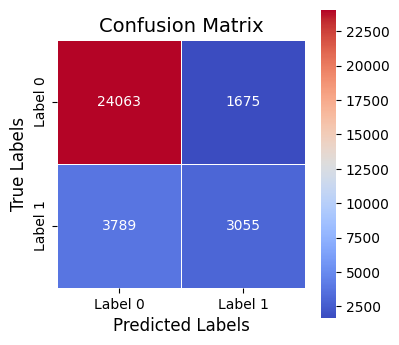

In [20]:


# Klassifikationsbericht erstellen
report = classification_report(y_test_token, predicted_classes_21, target_names=["Class 0", "Class 1"])
print("Classification Report:\n", report)

cm = confusion_matrix(y_test_token, predicted_classes_21)
print(cm)
# Verwirrungsmatrix visualisieren
plt.figure(figsize=(4, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="coolwarm", linewidths=0.5, square=True,
            xticklabels=["Label 0", "Label 1"], yticklabels=["Label 0", "Label 1"])
plt.xlabel("Predicted Labels", fontsize=12)
plt.ylabel("True Labels", fontsize=12)
plt.title("Confusion Matrix", fontsize=14)
plt.show()

### Vektorisierung

#### GloVe 

In [5]:
twitter_glove_path = os.path.abspath(os.path.join(src_path, 'src/3. Deep Learning Approach/nasiba/glove.6B.200d.txt'))

X_train_vectors, X_test_vectors, y_train, y_test, glove_embeddings, tokenizer = vectorize_glove_new(
    df=df_cleaned, text_column="tweet_cleaned", label_column="label", glove_path=twitter_glove_path
)

X_test_data_vectors, y_test_data, glove_embeddings_test, tokenizer_test, _, _ = vectorize_glove_new(
    df=df_cleaned_test, text_column="tweet_cleaned", label_column="label",
    glove_path=twitter_glove_path, tokenizer=tokenizer  # Nutzt den bereits gelernten Tokenizer!
)



c:\Users\Nasiba\Documents\1 Master Data Science\Projektpraktikum\WebScience24\src\3. Deep Learning Approach\nasiba\vector_functions.py:946: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[text_column] = df[text_column].astype(str)
c:\Users\Nasiba\Documents\1 Master Data Science\Projektpraktikum\WebScience24\src\3. Deep Learning Approach\nasiba\vector_functions.py:946: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[text_column] = df[text_column].astype(str)


In [ ]:


twitter_glove_path = os.path.abspath(os.path.join(src_path, 'src/3. Deep Learning Approach/nasiba/glove.6B.200d.txt'))


X_train_vectors_3, X_test_vectors_3, y_train_3, y_test_3, glove_embeddings_3,tokenizer_3 = vectorize_glove_3(df=df_cleaned, text_column ="tweet_cleaned", label_column="label", glove_path=twitter_glove_path)

X_test_data_vectors_3 , y_test_data_3, glove_embeddings_3_test,tokenizer_3_test = vectorize_glove_test_data_3(df=df_cleaned_test, text_column ="tweet_cleaned", label_column="label", glove_path=twitter_glove_path, tokenizer=tokenizer_3)


c:\Users\Nasiba\Documents\1 Master Data Science\Projektpraktikum\WebScience24\src\3. Deep Learning Approach\nasiba\vector_functions.py:665: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[text_column] = df[text_column].astype(str)
c:\Users\Nasiba\Documents\1 Master Data Science\Projektpraktikum\WebScience24\src\3. Deep Learning Approach\nasiba\vector_functions.py:856: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[text_column] = df[text_column].astype(str)


In [4]:


twitter_glove_path = os.path.abspath(os.path.join(src_path, 'src/3. Deep Learning Approach/nasiba/glove.6B.200d.txt'))


X_train_vectors_2, X_test_vectors_2, y_train_2, y_test_2, glove_embeddings_2,tokenizer_2 = vectorize_glove_2(df=df_cleaned, text_column ="tweet_cleaned", label_column="label", glove_path=twitter_glove_path)

X_test_data_vectors_2 , y_test_data_2, glove_embeddings_2_test,tokenizer_2_test = vectorize_glove_test_data_2(df=df_cleaned_test, text_column ="tweet_cleaned", label_column="label", glove_path=twitter_glove_path, tokenizer=tokenizer_2)


c:\Users\Nasiba\Documents\1 Master Data Science\Projektpraktikum\WebScience24\src\3. Deep Learning Approach\nasiba\vector_functions.py:602: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[text_column] = df[text_column].astype(str)
c:\Users\Nasiba\Documents\1 Master Data Science\Projektpraktikum\WebScience24\src\3. Deep Learning Approach\nasiba\vector_functions.py:807: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[text_column] = df[text_column].astype(str)


In [7]:


twitter_glove_path = os.path.abspath(os.path.join(src_path, 'src/3. Deep Learning Approach/nasiba/glove.6B.200d.txt'))


X_train_vectors, X_test_vectors, y_train, y_test, glove_embeddings = vectorize_glove(df=df_cleaned, text_column ="tweet_cleaned", label_column="label", glove_path=twitter_glove_path)

X_test_data_vectors , y_test_data, glove_embeddings = vectorize_glove_test_data(df=df_cleaned_test, text_column ="tweet_cleaned", label_column="label", glove_path=twitter_glove_path)


c:\Users\Nasiba\Documents\1 Master Data Science\Projektpraktikum\WebScience24\src\3. Deep Learning Approach\nasiba\vector_functions.py:394: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[text_column] = df[text_column].astype(str)
c:\Users\Nasiba\Documents\1 Master Data Science\Projektpraktikum\WebScience24\src\3. Deep Learning Approach\nasiba\vector_functions.py:527: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[text_column] = df[text_column].astype(str)


#### Fastext

In [ ]:



X_train_vectors_fast, X_test_vectors_fast, y_train_fast, y_test_fast, ft_model,tokenizer_fast = vectorize_fasttext_2(df=df_cleaned, text_column ="tweet_cleaned", label_column="label")

X_test_data_vectors_test_fast , y_test_data_test_fast, ft_model_test,tokenizer_test_fast = vectorize_fasttext_test_data(df=df_cleaned_test, text_column ="tweet_cleaned", label_column="label",  tokenizer=tokenizer_fast)


c:\Users\Nasiba\Documents\1 Master Data Science\Projektpraktikum\WebScience24\src\3. Deep Learning Approach\nasiba\vector_functions.py:345: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[text_column] = df[text_column].astype(str)
c:\Users\Nasiba\Documents\1 Master Data Science\Projektpraktikum\WebScience24\src\3. Deep Learning Approach\nasiba\vector_functions.py:411: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[text_column] = df[text_column].astype(str)


### Modell aufbauen 

#### Word2Vec

In [5]:

X_train_w2v, X_test_w2v, y_train_wv, y_test_vw, w2v_model = vectorize_word2vec(df=df_cleaned, text_column ="tweet_cleaned", label_column="label")


X_test_w2v_data, y_test_wv_data, w2v_model = vectorize_word2vec_test_data(df=df_cleaned, text_column ="tweet_cleaned", label_column="label")

# X_test_w2v_data, y_test_wv_data, w2v_model = vectorize_word2vec_test_data(df=df_cleaned, text_column ="tweet_cleaned", label_column="label")



c:\Users\Nasiba\Documents\1 Master Data Science\Projektpraktikum\WebScience24\src\3. Deep Learning Approach\nasiba\vector_functions.py:162: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[text_column] = df[text_column].astype(str)
c:\Users\Nasiba\Documents\1 Master Data Science\Projektpraktikum\WebScience24\src\3. Deep Learning Approach\nasiba\vector_functions.py:217: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[text_column] = df[text_column].astype(str)


In [8]:

samples_w2v, max_seq_len_w2v, vector_size_w2v = X_train_w2v.shape
num_classes_w2v = len(np.unique(y_train_wv))
# Modellinitialisierung
model_w2v = Sequential()

# LSTM-Schicht
model_w2v.add(LSTM(units=128, input_shape=(max_seq_len_w2v, vector_size_w2v), return_sequences=False))

# Optional: Dropout zur Vermeidung von Overfitting
model_w2v.add(Dropout(0.5))

# Dense-Schicht für die Ausgabe
model_w2v.add(Dense(units=1, activation='sigmoid'))

# Kompilieren des Modells
model_w2v.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy', Recall()])

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=0.00001)

class_weight = {0: 1, 1: 3} 

history_model_w2v = model_w2v.fit(
    X_train_w2v,np.array(y_train_wv),
    validation_data=(X_test_w2v, np.array(y_test_vw)),
    epochs=50,
    batch_size=32,
    callbacks=[early_stopping,reduce_lr],
    class_weight=class_weight,
    verbose=1
)
predictions_w2v = model_w2v.predict(X_test_w2v_data)
threshold = 0.4
predicted_classes_w2v = (predictions_w2v> threshold).astype(int)


Epoch 1/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 106s 56ms/step - accuracy: 0.8167 - loss: 0.4775 - recall_1: 0.0083 - val_accuracy: 0.8252 - val_loss: 0.3952 - val_recall_1: 0.2057 - learning_rate: 0.0010
Epoch 2/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 100s 55ms/step - accuracy: 0.8266 - loss: 0.3833 - recall_1: 0.2087 - val_accuracy: 0.8462 - val_loss: 0.3669 - val_recall_1: 0.2840 - learning_rate: 0.0010
Epoch 3/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 100s 55ms/step - accuracy: 0.8474 - loss: 0.3546 - recall_1: 0.3005 - val_accuracy: 0.8490 - val_loss: 0.3618 - val_recall_1: 0.3626 - learning_rate: 0.0010
Epoch 4/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 95s 52ms/step - accuracy: 0.8507 - loss: 0.3465 - recall_1: 0.3415 - val_accuracy: 0.8526 - val_loss: 0.3517 - val_recall_1: 0.3698 - learning_rate: 0.0010
Epoch 5/50
1822/1822 ━━━━━━━━━━━━━━━━━━━━ 93s 51ms/step - accuracy: 0.8561 - loss: 0.3354 - recall_1: 0.3533 - val_accuracy: 0.8534 - val_loss: 0.3529 - val_recall_1: 0.3336 - learning_rate: 0.0010
Epoch 6

Classification Report:
               precision    recall  f1-score   support

     Class 0       0.85      0.93      0.88     68342
     Class 1       0.40      0.22      0.29     14929

    accuracy                           0.80     83271
   macro avg       0.62      0.58      0.59     83271
weighted avg       0.77      0.80      0.78     83271

[[63442  4900]
 [11619  3310]]


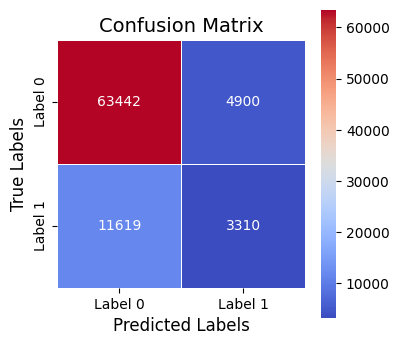

In [9]:


# Klassifikationsbericht erstellen
report = classification_report(y_test_wv_data, predicted_classes_w2v, target_names=["Class 0", "Class 1"])
print("Classification Report:\n", report)

cm = confusion_matrix(y_test_wv_data, predicted_classes_w2v)
print(cm)
# Verwirrungsmatrix visualisieren
plt.figure(figsize=(4, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="coolwarm", linewidths=0.5, square=True,
            xticklabels=["Label 0", "Label 1"], yticklabels=["Label 0", "Label 1"])
plt.xlabel("Predicted Labels", fontsize=12)
plt.ylabel("True Labels", fontsize=12)
plt.title("Confusion Matrix", fontsize=14)
plt.show()


#### Modeltraining mit anderen Parametern

(Aktivierungsfunktion in der Dense-Schicht zu sigmoid ändern, da diese für Binärklassifikation besser geeignet sein soll)

In [20]:
samples, max_seq_len, vector_size = X_train_vectors.shape
num_classes = len(np.unique(y_train))


# y_train_onehot = to_categorical(y_train, num_classes=num_classes)
# y_test_onehot = to_categorical(y_test, num_classes=num_classes)
# y_test_onehot_data = to_categorical(y_test_data, num_classes=num_classes)

# Modellinitialisierung
model_2 = Sequential()

# LSTM-Schicht
model_2.add(LSTM(units=128, input_shape=(max_seq_len, vector_size), return_sequences=False))

# Optional: Dropout zur Vermeidung von Overfitting
model_2.add(Dropout(0.5))

# Dense-Schicht für die Ausgabe
model_2.add(Dense(units=1, activation='sigmoid'))

# Kompilieren des Modells
model_2.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy', Recall()])

#class_weight = {0: 1, 1: 3} 
history_2 = model_2.fit(
    X_train_vectors, np.array(y_train),
    validation_data=(X_test_vectors, np.array(y_test)),
    epochs=10,
    batch_size=32,
    #class_weight=class_weight,
    verbose=2
)
# Vorhersagen auf Testdaten
predictions_2 = model_2.predict(X_test_data_vectors)
threshold = 0.5  # Oder teste 0.4 oder 0.6
predicted_classes_2 = (predictions_2 > threshold).astype(int)

Epoch 1/10
1792/1792 - 83s - 47ms/step - accuracy: 0.8309 - loss: 0.4011 - recall_3: 0.1889 - val_accuracy: 0.8444 - val_loss: 0.3714 - val_recall_3: 0.3772
Epoch 2/10
1792/1792 - 76s - 42ms/step - accuracy: 0.8455 - loss: 0.3662 - recall_3: 0.2928 - val_accuracy: 0.8495 - val_loss: 0.3646 - val_recall_3: 0.3890
Epoch 3/10
1792/1792 - 82s - 46ms/step - accuracy: 0.8535 - loss: 0.3473 - recall_3: 0.3545 - val_accuracy: 0.8504 - val_loss: 0.3530 - val_recall_3: 0.3036
Epoch 4/10
1792/1792 - 73s - 41ms/step - accuracy: 0.8607 - loss: 0.3312 - recall_3: 0.4009 - val_accuracy: 0.8523 - val_loss: 0.3739 - val_recall_3: 0.3933
Epoch 5/10
1792/1792 - 73s - 41ms/step - accuracy: 0.8678 - loss: 0.3133 - recall_3: 0.4449 - val_accuracy: 0.8508 - val_loss: 0.3549 - val_recall_3: 0.2866
Epoch 6/10
1792/1792 - 71s - 40ms/step - accuracy: 0.8760 - loss: 0.2933 - recall_3: 0.4913 - val_accuracy: 0.8511 - val_loss: 0.3617 - val_recall_3: 0.3430
Epoch 7/10
1792/1792 - 75s - 42ms/step - accuracy: 0.8857 

Classification Report:
               precision    recall  f1-score   support

     Class 0       0.88      0.88      0.88     25627
     Class 1       0.54      0.53      0.54      6839

    accuracy                           0.81     32466
   macro avg       0.71      0.71      0.71     32466
weighted avg       0.81      0.81      0.81     32466

[[22543  3084]
 [ 3195  3644]]


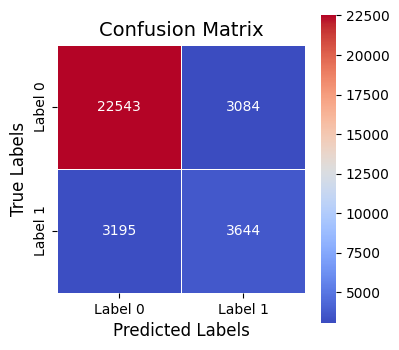

In [21]:


# Klassifikationsbericht erstellen
report = classification_report(y_test_data, predicted_classes_2, target_names=["Class 0", "Class 1"])
print("Classification Report:\n", report)

cm = confusion_matrix(y_test_data, predicted_classes_2)
print(cm)
# Verwirrungsmatrix visualisieren
plt.figure(figsize=(4, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="coolwarm", linewidths=0.5, square=True,
            xticklabels=["Label 0", "Label 1"], yticklabels=["Label 0", "Label 1"])
plt.xlabel("Predicted Labels", fontsize=12)
plt.ylabel("True Labels", fontsize=12)
plt.title("Confusion Matrix", fontsize=14)
plt.show()

#### Modeltraining mit anderen Parametern

(Aktivierungsfunktion in der Dense-Schicht zu sigmoid ändern,class_wight hinzufügen)

In [37]:
samples, max_seq_len, vector_size = X_train_vectors.shape
num_classes = len(np.unique(y_train))


# y_train_onehot = to_categorical(y_train, num_classes=num_classes)
# y_test_onehot = to_categorical(y_test, num_classes=num_classes)
# y_test_onehot_data = to_categorical(y_test_data, num_classes=num_classes)

# Modellinitialisierung
model_3 = Sequential()

# LSTM-Schicht
model_3.add(LSTM(units=128, input_shape=(max_seq_len, vector_size), return_sequences=False))

# Optional: Dropout zur Vermeidung von Overfitting
model_3.add(Dropout(0.5))

# Dense-Schicht für die Ausgabe
model_3.add(Dense(units=1, activation='sigmoid'))

# Kompilieren des Modells
model_3.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy', Recall()])

class_weight = {0: 1, 1: 3} 
history_3 = model_3.fit(
    X_train_vectors, np.array(y_train),
    validation_data=(X_test_vectors, np.array(y_test)),
    epochs=10,
    batch_size=32,
    class_weight=class_weight,
    verbose=2
)
# Vorhersagen auf Testdaten
predictions_3 = model_3.predict(X_test_data_vectors)
threshold = 0.5  # Oder teste 0.4 oder 0.6
predicted_classes_3 = (predictions_3 > threshold).astype(int)

C:\Users\Nasiba\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
1822/1822 - 84s - 46ms/step - accuracy: 0.7565 - loss: 0.8568 - recall_8: 0.3463 - val_accuracy: 0.7675 - val_loss: 0.4649 - val_recall_8: 0.6244
Epoch 2/10
1822/1822 - 72s - 39ms/step - accuracy: 0.7907 - loss: 0.7202 - recall_8: 0.6008 - val_accuracy: 0.7900 - val_loss: 0.4801 - val_recall_8: 0.6276
Epoch 3/10
1822/1822 - 75s - 41ms/step - accuracy: 0.8092 - loss: 0.6726 - recall_8: 0.6327 - val_accuracy: 0.7860 - val_loss: 0.4449 - val_recall_8: 0.6715
Epoch 4/10
1822/1822 - 74s - 41ms/step - accuracy: 0.8208 - loss: 0.6362 - recall_8: 0.6544 - val_accuracy: 0.7544 - val_loss: 0.4678 - val_recall_8: 0.7382
Epoch 5/10
1822/1822 - 80s - 44ms/step - accuracy: 0.8262 - loss: 0.6050 - recall_8: 0.6863 - val_accuracy: 0.8065 - val_loss: 0.4284 - val_recall_8: 0.6338
Epoch 6/10
1822/1822 - 85s - 47ms/step - accuracy: 0.8394 - loss: 0.5700 - recall_8: 0.7071 - val_accuracy: 0.8257 - val_loss: 0.3942 - val_recall_8: 0.5834
Epoch 7/10
1822/1822 - 93s - 51ms/step - accuracy: 0.8484 

Classification Report:
               precision    recall  f1-score   support

     Class 0       0.90      0.83      0.86     25685
     Class 1       0.50      0.64      0.56      6844

    accuracy                           0.79     32529
   macro avg       0.70      0.73      0.71     32529
weighted avg       0.81      0.79      0.80     32529

[[21220  4465]
 [ 2454  4390]]


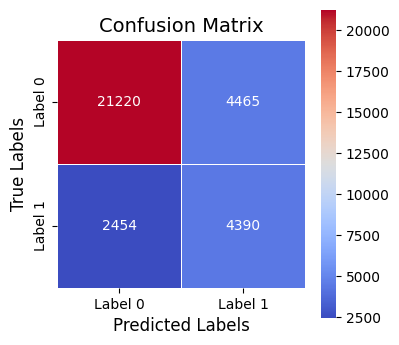

In [38]:


# Klassifikationsbericht erstellen
report = classification_report(y_test_data, predicted_classes_3, target_names=["Class 0", "Class 1"])
print("Classification Report:\n", report)

cm = confusion_matrix(y_test_data, predicted_classes_3)
print(cm)
# Verwirrungsmatrix visualisieren
plt.figure(figsize=(4, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="coolwarm", linewidths=0.5, square=True,
            xticklabels=["Label 0", "Label 1"], yticklabels=["Label 0", "Label 1"])
plt.xlabel("Predicted Labels", fontsize=12)
plt.ylabel("True Labels", fontsize=12)
plt.title("Confusion Matrix", fontsize=14)
plt.show()

Model_3 mit anderem Tokenizer

In [ ]:
samples, max_seq_len, vector_size = X_train_vectors_3.shape
num_classes = len(np.unique(y_train_2))


# y_train_onehot = to_categorical(y_train, num_classes=num_classes)
# y_test_onehot = to_categorical(y_test, num_classes=num_classes)
# y_test_onehot_data = to_categorical(y_test_data, num_classes=num_classes)

# Modellinitialisierung
model_3_tok = Sequential()

# LSTM-Schicht
model_3_tok.add(LSTM(units=128, input_shape=(max_seq_len, vector_size), return_sequences=False))

# Optional: Dropout zur Vermeidung von Overfitting
model_3_tok.add(Dropout(0.5))

# Dense-Schicht für die Ausgabe
model_3_tok.add(Dense(units=1, activation='sigmoid'))

# Kompilieren des Modells
model_3_tok.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy', Recall()])

class_weight = {0: 1, 1: 3} 
history_3_tok = model_3_tok.fit(
    X_train_vectors_2, np.array(y_train_2),
    validation_data=(X_test_vectors_2, np.array(y_test_2)),
    epochs=10,
    batch_size=32,
    class_weight=class_weight,
    verbose=2
)
# Vorhersagen auf Testdaten
predictions_3_tok = model_3_tok.predict(X_test_data_vectors_2)
threshold = 0.5  # Oder teste 0.4 oder 0.6
predicted_classes_3_tok = (predictions_3_tok > threshold).astype(int)

In [ ]:


# Klassifikationsbericht erstellen
report = classification_report(y_test_data_2, predicted_classes_3_tok, target_names=["Class 0", "Class 1"])
print("Classification Report:\n", report)

cm = confusion_matrix(y_test_data_2, predicted_classes_3_tok)
print(cm)
# Verwirrungsmatrix visualisieren
plt.figure(figsize=(4, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="coolwarm", linewidths=0.5, square=True,
            xticklabels=["Label 0", "Label 1"], yticklabels=["Label 0", "Label 1"])
plt.xlabel("Predicted Labels", fontsize=12)
plt.ylabel("True Labels", fontsize=12)
plt.title("Confusion Matrix", fontsize=14)
plt.show()

Recall speziel für Klasse 1 festlegen: muss man in sigmoid nicht, da er dies automatisch macht

Epcohenerhöhung, dropout Reduzierung 

In [22]:
samples, max_seq_len, vector_size = X_train_vectors.shape
num_classes = len(np.unique(y_train))


# y_train_onehot = to_categorical(y_train, num_classes=num_classes)
# y_test_onehot = to_categorical(y_test, num_classes=num_classes)
# y_test_onehot_data = to_categorical(y_test_data, num_classes=num_classes)

# Modellinitialisierung
model_10 = Sequential()

# LSTM-Schicht
model_10.add(LSTM(units=128, input_shape=(max_seq_len, vector_size), return_sequences=False))

# Optional: Dropout zur Vermeidung von Overfitting
model_10.add(Dropout(0.3))

# Dense-Schicht für die Ausgabe
model_10.add(Dense(units=1, activation='sigmoid'))

# Kompilieren des Modells
model_10.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy', Recall()])

class_weight = {0: 1, 1: 3} 
history_10 = model_10.fit(
    X_train_vectors, np.array(y_train),
    validation_data=(X_test_vectors, np.array(y_test)),
    epochs=20,
    batch_size=32,
    class_weight=class_weight,
    verbose=2
)
# Vorhersagen auf Testdaten

predictions_10 = model_10.predict(X_test_data_vectors)

threshold = 0.5  # Oder teste 0.4 oder 0.6
predicted_classes_10= (predictions_10 > threshold).astype(int)



C:\Users\Nasiba\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
1792/1792 - 83s - 46ms/step - accuracy: 0.7696 - loss: 0.7548 - recall_4: 0.5675 - val_accuracy: 0.8016 - val_loss: 0.4640 - val_recall_4: 0.5875
Epoch 2/20
1792/1792 - 81s - 45ms/step - accuracy: 0.7959 - loss: 0.6918 - recall_4: 0.6290 - val_accuracy: 0.8003 - val_loss: 0.5225 - val_recall_4: 0.6310
Epoch 3/20
1792/1792 - 80s - 45ms/step - accuracy: 0.8102 - loss: 0.6585 - recall_4: 0.6484 - val_accuracy: 0.8019 - val_loss: 0.4402 - val_recall_4: 0.6459
Epoch 4/20
1792/1792 - 93s - 52ms/step - accuracy: 0.8170 - loss: 0.6259 - recall_4: 0.6839 - val_accuracy: 0.8322 - val_loss: 0.3981 - val_recall_4: 0.5608
Epoch 5/20
1792/1792 - 81s - 45ms/step - accuracy: 0.8290 - loss: 0.5903 - recall_4: 0.7090 - val_accuracy: 0.8144 - val_loss: 0.4261 - val_recall_4: 0.6482
Epoch 6/20
1792/1792 - 77s - 43ms/step - accuracy: 0.8394 - loss: 0.5499 - recall_4: 0.7436 - val_accuracy: 0.7454 - val_loss: 0.4687 - val_recall_4: 0.7772
Epoch 7/20
1792/1792 - 75s - 42ms/step - accuracy: 0.8530 

Classification Report:
               precision    recall  f1-score   support

     Class 0       0.88      0.86      0.87     25627
     Class 1       0.51      0.56      0.54      6839

    accuracy                           0.80     32466
   macro avg       0.70      0.71      0.70     32466
weighted avg       0.80      0.80      0.80     32466

[[22016  3611]
 [ 3006  3833]]


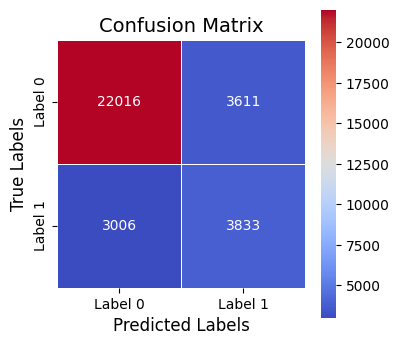

In [23]:


# Klassifikationsbericht erstellen
report = classification_report(y_test_data, predicted_classes_10, target_names=["Class 0", "Class 1"])
print("Classification Report:\n", report)

cm = confusion_matrix(y_test_data, predicted_classes_10)
print(cm)
# Verwirrungsmatrix visualisieren
plt.figure(figsize=(4, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="coolwarm", linewidths=0.5, square=True,
            xticklabels=["Label 0", "Label 1"], yticklabels=["Label 0", "Label 1"])
plt.xlabel("Predicted Labels", fontsize=12)
plt.ylabel("True Labels", fontsize=12)
plt.title("Confusion Matrix", fontsize=14)
plt.show()

Epcohenerhöhung/dropuot reduzierung mit anderer lernrate

In [ ]:
samples, max_seq_len, vector_size = X_train_vectors.shape
num_classes = len(np.unique(y_train))
# Modellinitialisierung
model_13 = Sequential()

# LSTM-Schicht
model_13.add(LSTM(units=128, input_shape=(max_seq_len, vector_size), return_sequences=False))

# Optional: Dropout zur Vermeidung von Overfitting
model_13.add(Dropout(0.3))

# Dense-Schicht für die Ausgabe
model_13.add(Dense(units=1, activation='sigmoid'))

# Kompilieren des Modells mit verbesserter Lernrate
model_13.compile(optimizer=Adam(learning_rate=0.0003),
                 loss='binary_crossentropy',
                 metrics=['accuracy', Recall()])

class_weight = {0: 1, 1: 3}

history_13 = model_13.fit(
    X_train_vectors, np.array(y_train),
    validation_data=(X_test_vectors, np.array(y_test)),
    epochs=20,
    
    batch_size=32,
    class_weight=class_weight,
    verbose=2
)

# Vorhersagen auf Testdaten
predictions_13 = model_13.predict(X_test_data_vectors)
threshold = 0.5  # Oder teste 0.4 oder 0.6
predicted_classes_13 = (predictions_13 > threshold).astype(int)


C:\Users\Nasiba\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
1823/1823 - 99s - 54ms/step - accuracy: 0.7572 - loss: 0.7670 - recall: 0.5522 - val_accuracy: 0.8027 - val_loss: 0.4364 - val_recall: 0.5371
Epoch 2/20
1823/1823 - 82s - 45ms/step - accuracy: 0.7917 - loss: 0.6959 - recall: 0.6111 - val_accuracy: 0.7971 - val_loss: 0.4412 - val_recall: 0.6184
Epoch 3/20
1823/1823 - 89s - 49ms/step - accuracy: 0.8008 - loss: 0.6651 - recall: 0.6365 - val_accuracy: 0.7802 - val_loss: 0.4552 - val_recall: 0.6739
Epoch 4/20
1823/1823 - 86s - 47ms/step - accuracy: 0.8076 - loss: 0.6446 - recall: 0.6485 - val_accuracy: 0.8205 - val_loss: 0.3928 - val_recall: 0.5910
Epoch 5/20
1823/1823 - 92s - 51ms/step - accuracy: 0.8140 - loss: 0.6232 - recall: 0.6678 - val_accuracy: 0.8020 - val_loss: 0.4193 - val_recall: 0.6682
Epoch 6/20
1823/1823 - 90s - 49ms/step - accuracy: 0.8178 - loss: 0.6025 - recall: 0.6902 - val_accuracy: 0.8177 - val_loss: 0.4012 - val_recall: 0.6184
Epoch 7/20
1823/1823 - 93s - 51ms/step - accuracy: 0.8228 - loss: 0.5802 - recall:

Classification Report:
               precision    recall  f1-score   support

     Class 0       0.90      0.78      0.84     25685
     Class 1       0.45      0.68      0.54      6844

    accuracy                           0.76     32529
   macro avg       0.68      0.73      0.69     32529
weighted avg       0.81      0.76      0.78     32529

[[20108  5577]
 [ 2196  4648]]


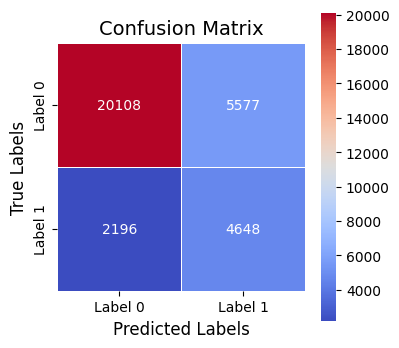

In [6]:


# Klassifikationsbericht erstellen
report = classification_report(y_test_data, predicted_classes_13, target_names=["Class 0", "Class 1"])
print("Classification Report:\n", report)

cm = confusion_matrix(y_test_data, predicted_classes_13)
print(cm)
# Verwirrungsmatrix visualisieren
plt.figure(figsize=(4, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="coolwarm", linewidths=0.5, square=True,
            xticklabels=["Label 0", "Label 1"], yticklabels=["Label 0", "Label 1"])
plt.xlabel("Predicted Labels", fontsize=12)
plt.ylabel("True Labels", fontsize=12)
plt.title("Confusion Matrix", fontsize=14)
plt.show()

Dropout Erhöhung

In [7]:
samples, max_seq_len, vector_size = X_train_vectors.shape
num_classes = len(np.unique(y_train))
# Modellinitialisierung
model_14 = Sequential()

# LSTM-Schicht
model_14.add(LSTM(units=128, input_shape=(max_seq_len, vector_size), return_sequences=False))

# Optional: Dropout zur Vermeidung von Overfitting
model_14.add(Dropout(0.6))

# Dense-Schicht für die Ausgabe
model_14.add(Dense(units=1, activation='sigmoid'))

# Kompilieren des Modells mit verbesserter Lernrate
model_14.compile(optimizer=Adam(learning_rate=0.0003),
                 loss='binary_crossentropy',
                 metrics=['accuracy', Recall()])

class_weight = {0: 1, 1: 3}
# early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history_14 = model_14.fit(
    X_train_vectors, np.array(y_train),
    validation_data=(X_test_vectors, np.array(y_test)),
    epochs=20,
    batch_size=32,
    class_weight=class_weight,
    verbose=2
)

# Vorhersagen auf Testdaten
predictions_14 = model_14.predict(X_test_data_vectors)
threshold = 0.5  # Oder teste 0.4 oder 0.6
predicted_classes_14 = (predictions_14 > threshold).astype(int)


C:\Users\Nasiba\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
1823/1823 - 94s - 51ms/step - accuracy: 0.7638 - loss: 0.7777 - recall_1: 0.5230 - val_accuracy: 0.8274 - val_loss: 0.3886 - val_recall_1: 0.4066
Epoch 2/20
1823/1823 - 95s - 52ms/step - accuracy: 0.7914 - loss: 0.6958 - recall_1: 0.6204 - val_accuracy: 0.8265 - val_loss: 0.3871 - val_recall_1: 0.4923
Epoch 3/20
1823/1823 - 93s - 51ms/step - accuracy: 0.7991 - loss: 0.6691 - recall_1: 0.6386 - val_accuracy: 0.8218 - val_loss: 0.3900 - val_recall_1: 0.5691
Epoch 4/20
1823/1823 - 97s - 53ms/step - accuracy: 0.8057 - loss: 0.6487 - recall_1: 0.6514 - val_accuracy: 0.7644 - val_loss: 0.4749 - val_recall_1: 0.7390
Epoch 5/20
1823/1823 - 94s - 52ms/step - accuracy: 0.8099 - loss: 0.6258 - recall_1: 0.6697 - val_accuracy: 0.7518 - val_loss: 0.4540 - val_recall_1: 0.7568
Epoch 6/20
1823/1823 - 104s - 57ms/step - accuracy: 0.8134 - loss: 0.6071 - recall_1: 0.6935 - val_accuracy: 0.7628 - val_loss: 0.4555 - val_recall_1: 0.7511
Epoch 7/20
1823/1823 - 94s - 51ms/step - accuracy: 0.8168

Classification Report:
               precision    recall  f1-score   support

     Class 0       0.89      0.81      0.85     25685
     Class 1       0.47      0.64      0.54      6844

    accuracy                           0.77     32529
   macro avg       0.68      0.72      0.69     32529
weighted avg       0.80      0.77      0.78     32529

[[20793  4892]
 [ 2496  4348]]


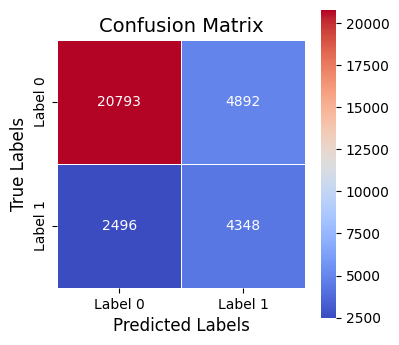

In [10]:


# Klassifikationsbericht erstellen
report = classification_report(y_test_data, predicted_classes_14, target_names=["Class 0", "Class 1"])
print("Classification Report:\n", report)

cm = confusion_matrix(y_test_data, predicted_classes_14)
print(cm)
# Verwirrungsmatrix visualisieren
plt.figure(figsize=(4, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="coolwarm", linewidths=0.5, square=True,
            xticklabels=["Label 0", "Label 1"], yticklabels=["Label 0", "Label 1"])
plt.xlabel("Predicted Labels", fontsize=12)
plt.ylabel("True Labels", fontsize=12)
plt.title("Confusion Matrix", fontsize=14)
plt.show()

Earlystop Aktivierung + Dropout Erhöhung + epochen erhöhung + learning rate dynamisieren

In [ ]:
from tensorflow.keras.callbacks import ReduceLROnPlateau
samples, max_seq_len, vector_size = X_train_vectors.shape
num_classes = len(np.unique(y_train))
# Modellinitialisierung
model_17 = Sequential()

# LSTM-Schicht
model_17.add(LSTM(units=128, input_shape=(max_seq_len, vector_size), return_sequences=False))

# Optional: Dropout zur Vermeidung von Overfitting
model_17.add(Dropout(0.35))

# Dense-Schicht für die Ausgabe
model_17.add(Dense(units=1, activation='sigmoid'))

# Kompilieren des Modells mit verbesserter Lernrate
model_17.compile(optimizer=Adam(),
                 loss='binary_crossentropy',
                 metrics=['accuracy', Recall()])

class_weight = {0: 1, 1: 3}
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=0.00001)

history_17 = model_17.fit(
    X_train_vectors, np.array(y_train),
    validation_data=(X_test_vectors, np.array(y_test)),
    epochs=50,
    batch_size=32,
    callbacks=[early_stopping,reduce_lr],
    class_weight=class_weight,
    verbose=2
)

# Vorhersagen auf Testdaten
predictions_17 = model_17.predict(X_test_data_vectors)
threshold = 0.5  # Oder teste 0.4 oder 0.6
predicted_classes_17 = (predictions_17 > threshold).astype(int)

# keras tuner


C:\Users\Nasiba\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
1822/1822 - 107s - 59ms/step - accuracy: 0.7940 - loss: 0.9047 - recall_3: 0.1427 - val_accuracy: 0.8216 - val_loss: 0.5757 - val_recall_3: 0.0040 - learning_rate: 0.0010
Epoch 2/50
1822/1822 - 94s - 52ms/step - accuracy: 0.7683 - loss: 0.8224 - recall_3: 0.4174 - val_accuracy: 0.7850 - val_loss: 0.4371 - val_recall_3: 0.6201 - learning_rate: 0.0010
Epoch 3/50
1822/1822 - 91s - 50ms/step - accuracy: 0.7953 - loss: 0.6915 - recall_3: 0.6254 - val_accuracy: 0.8033 - val_loss: 0.4763 - val_recall_3: 0.6006 - learning_rate: 0.0010
Epoch 4/50
1822/1822 - 94s - 52ms/step - accuracy: 0.8097 - loss: 0.6476 - recall_3: 0.6601 - val_accuracy: 0.8220 - val_loss: 0.4016 - val_recall_3: 0.5793 - learning_rate: 0.0010
Epoch 5/50
1822/1822 - 98s - 54ms/step - accuracy: 0.8155 - loss: 0.6233 - recall_3: 0.6895 - val_accuracy: 0.8324 - val_loss: 0.3910 - val_recall_3: 0.5427 - learning_rate: 0.0010
Epoch 6/50
1822/1822 - 162s - 89ms/step - accuracy: 0.8275 - loss: 0.5826 - recall_3: 0.7203 -

In [ ]:
# Vorhersagen auf Testdaten
predictions_17_2 = model_17.predict(X_test_data_vectors)
threshold = 0.35  # Oder teste 0.4 oder 0.6
predicted_classes_17_2 = (predictions_17_2 > threshold).astype(int)


1017/1017 ━━━━━━━━━━━━━━━━━━━━ 18s 17ms/step


Classification Report:
               precision    recall  f1-score   support

     Class 0       0.89      0.84      0.87     25685
     Class 1       0.52      0.63      0.57      6844

    accuracy                           0.80     32529
   macro avg       0.71      0.74      0.72     32529
weighted avg       0.82      0.80      0.81     32529

[[21700  3985]
 [ 2552  4292]]


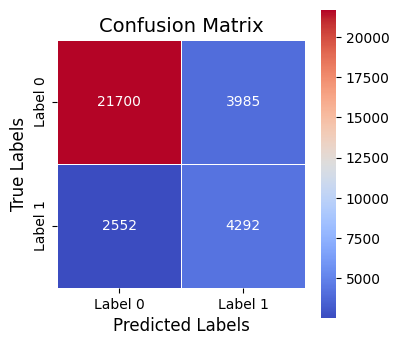

In [14]:


# Klassifikationsbericht erstellen
report = classification_report(y_test_data, predicted_classes_17, target_names=["Class 0", "Class 1"])
print("Classification Report:\n", report)

cm = confusion_matrix(y_test_data, predicted_classes_17)
print(cm)
# Verwirrungsmatrix visualisieren
plt.figure(figsize=(4, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="coolwarm", linewidths=0.5, square=True,
            xticklabels=["Label 0", "Label 1"], yticklabels=["Label 0", "Label 1"])
plt.xlabel("Predicted Labels", fontsize=12)
plt.ylabel("True Labels", fontsize=12)
plt.title("Confusion Matrix", fontsize=14)
plt.show()

threshold erhöht

In [ ]:
# Vorhersagen auf Testdaten
predictions_17_2 = model_17.predict(X_test_data_vectors)
threshold = 0.4  # Oder teste 0.4 oder 0.6
predicted_classes_17_2 = (predictions_17_2 > threshold).astype(int)


Classification Report:
               precision    recall  f1-score   support

     Class 0       0.92      0.74      0.82     25685
     Class 1       0.43      0.75      0.55      6844

    accuracy                           0.74     32529
   macro avg       0.67      0.74      0.68     32529
weighted avg       0.81      0.74      0.76     32529

[[18955  6730]
 [ 1728  5116]]


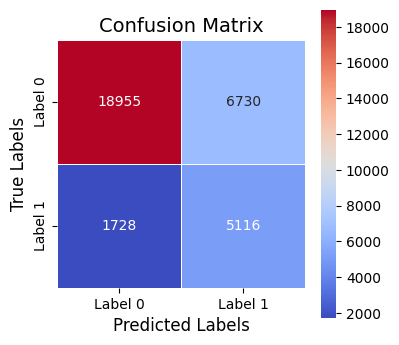

In [17]:


# Klassifikationsbericht erstellen
report = classification_report(y_test_data, predicted_classes_17_2, target_names=["Class 0", "Class 1"])
print("Classification Report:\n", report)

cm = confusion_matrix(y_test_data, predicted_classes_17_2)
print(cm)
# Verwirrungsmatrix visualisieren
plt.figure(figsize=(4, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="coolwarm", linewidths=0.5, square=True,
            xticklabels=["Label 0", "Label 1"], yticklabels=["Label 0", "Label 1"])
plt.xlabel("Predicted Labels", fontsize=12)
plt.ylabel("True Labels", fontsize=12)
plt.title("Confusion Matrix", fontsize=14)
plt.show()

In [18]:
predictions_17_3 = model_17.predict(X_test_data_vectors)
threshold = 0.6  # Oder teste 0.4 oder 0.6
predicted_classes_17_3 = (predictions_17_3 > threshold).astype(int)

1017/1017 ━━━━━━━━━━━━━━━━━━━━ 19s 19ms/step


Classification Report:
               precision    recall  f1-score   support

     Class 0       0.88      0.90      0.89     25685
     Class 1       0.58      0.53      0.56      6844

    accuracy                           0.82     32529
   macro avg       0.73      0.72      0.72     32529
weighted avg       0.82      0.82      0.82     32529

[[23021  2664]
 [ 3186  3658]]


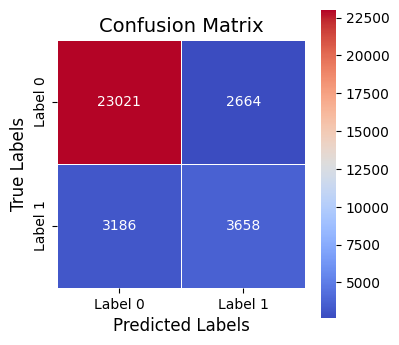

In [19]:


# Klassifikationsbericht erstellen
report = classification_report(y_test_data, predicted_classes_17_3, target_names=["Class 0", "Class 1"])
print("Classification Report:\n", report)

cm = confusion_matrix(y_test_data, predicted_classes_17_3)
print(cm)
# Verwirrungsmatrix visualisieren
plt.figure(figsize=(4, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="coolwarm", linewidths=0.5, square=True,
            xticklabels=["Label 0", "Label 1"], yticklabels=["Label 0", "Label 1"])
plt.xlabel("Predicted Labels", fontsize=12)
plt.ylabel("True Labels", fontsize=12)
plt.title("Confusion Matrix", fontsize=14)
plt.show()

Earlystop Aktivierung + Dropout Standard gelassen + epochen erhöhung + learning rate dynamisieren

In [ ]:

samples, max_seq_len, vector_size = X_train_vectors.shape
num_classes = len(np.unique(y_train))
# Modellinitialisierung
model_21 = Sequential()

# LSTM-Schicht
model_21.add(LSTM(units=128, input_shape=(max_seq_len, vector_size), return_sequences=False))

# Optional: Dropout zur Vermeidung von Overfitting
model_21.add(Dropout(0.5))

# Dense-Schicht für die Ausgabe
model_21.add(Dense(units=1, activation='sigmoid'))

# Kompilieren des Modells mit verbesserter Lernrate
model_21.compile(optimizer=Adam(),
                 loss='binary_crossentropy',
                 metrics=['accuracy', Recall()])

#class_weight = {0: 1, 1: 3}
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=0.00001)

history_21 = model_21.fit(
    X_train_vectors, np.array(y_train),
    validation_data=(X_test_vectors, np.array(y_test)),
    epochs=50,
    batch_size=32,
    callbacks=[early_stopping,reduce_lr],
    #class_weight=class_weight,
    verbose=2
)

# Vorhersagen auf Testdaten
predictions_21= model_21.predict(X_test_data_vectors)
threshold = 0.5  # Oder teste 0.4 oder 0.6
predicted_classes_21 = (predictions_21 > threshold).astype(int)





C:\Users\Nasiba\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
1823/1823 - 71s - 39ms/step - accuracy: 0.7773 - loss: 0.7741 - recall: 0.5228 - val_accuracy: 0.7919 - val_loss: 0.4592 - val_recall: 0.6184 - learning_rate: 0.0010
Epoch 2/50
1823/1823 - 92s - 50ms/step - accuracy: 0.8045 - loss: 0.6892 - recall: 0.6017 - val_accuracy: 0.8087 - val_loss: 0.4034 - val_recall: 0.6364 - learning_rate: 0.0010
Epoch 3/50
1823/1823 - 96s - 53ms/step - accuracy: 0.8121 - loss: 0.6542 - recall: 0.6314 - val_accuracy: 0.7975 - val_loss: 0.4546 - val_recall: 0.6809 - learning_rate: 0.0010
Epoch 4/50
1823/1823 - 81s - 44ms/step - accuracy: 0.8221 - loss: 0.6196 - recall: 0.6574 - val_accuracy: 0.7881 - val_loss: 0.4403 - val_recall: 0.6993 - learning_rate: 0.0010
Epoch 5/50
1823/1823 - 85s - 47ms/step - accuracy: 0.8272 - loss: 0.5854 - recall: 0.6975 - val_accuracy: 0.7728 - val_loss: 0.4471 - val_recall: 0.7145 - learning_rate: 0.0010
Epoch 6/50
1823/1823 - 75s - 41ms/step - accuracy: 0.8410 - loss: 0.5247 - recall: 0.7525 - val_accuracy: 0.8182 - 

Classification Report:
               precision    recall  f1-score   support

     Class 0       0.90      0.81      0.85     25685
     Class 1       0.47      0.65      0.55      6844

    accuracy                           0.77     32529
   macro avg       0.68      0.73      0.70     32529
weighted avg       0.81      0.77      0.79     32529

[[20745  4940]
 [ 2428  4416]]


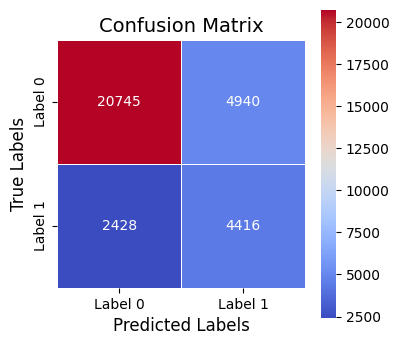

In [10]:


# Klassifikationsbericht erstellen
report = classification_report(y_test_data, predicted_classes_21, target_names=["Class 0", "Class 1"])
print("Classification Report:\n", report)

cm = confusion_matrix(y_test_data, predicted_classes_21)
print(cm)
# Verwirrungsmatrix visualisieren
plt.figure(figsize=(4, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="coolwarm", linewidths=0.5, square=True,
            xticklabels=["Label 0", "Label 1"], yticklabels=["Label 0", "Label 1"])
plt.xlabel("Predicted Labels", fontsize=12)
plt.ylabel("True Labels", fontsize=12)
plt.title("Confusion Matrix", fontsize=14)
plt.show()

model_21 mit anderem tokenizer

In [5]:

samples, max_seq_len, vector_size = X_train_vectors_2.shape
num_classes = len(np.unique(y_train_2))
# Modellinitialisierung
model_21_tok = Sequential()

# LSTM-Schicht
model_21_tok.add(LSTM(units=128, input_shape=(max_seq_len, vector_size), return_sequences=False))

# Optional: Dropout zur Vermeidung von Overfitting
model_21_tok.add(Dropout(0.5))

# Dense-Schicht für die Ausgabe
model_21_tok.add(Dense(units=1, activation='sigmoid'))

# Kompilieren des Modells mit verbesserter Lernrate
model_21_tok.compile(optimizer=Adam(),
                 loss='binary_crossentropy',
                 metrics=['accuracy', Recall()])

# class_weight = {0: 1, 1: 3}
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=0.00001)

history_21_tok = model_21_tok.fit(
    X_train_vectors_2, np.array(y_train_2),
    validation_data=(X_test_vectors_2, np.array(y_test_2)),
    epochs=50,
    batch_size=32,
    callbacks=[early_stopping,reduce_lr],
    #class_weight=class_weight,
    verbose=2
)

# Vorhersagen auf Testdaten
predictions_21_tok= model_21_tok.predict(X_test_data_vectors_2)
threshold=0.35 # Oder teste 0.4 oder 0.6
predicted_classes_21_tok = (predictions_21_tok > threshold).astype(int)





C:\Users\Nasiba\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
2996/2996 - 150s - 50ms/step - accuracy: 0.7122 - loss: 0.5482 - recall: 0.7256 - val_accuracy: 0.7802 - val_loss: 0.4771 - val_recall: 0.7132 - learning_rate: 0.0010
Epoch 2/50
2996/2996 - 128s - 43ms/step - accuracy: 0.7944 - loss: 0.4391 - recall: 0.8336 - val_accuracy: 0.7071 - val_loss: 0.5309 - val_recall: 0.8173 - learning_rate: 0.0010
Epoch 3/50
2996/2996 - 132s - 44ms/step - accuracy: 0.8514 - loss: 0.3515 - recall: 0.8943 - val_accuracy: 0.7988 - val_loss: 0.4818 - val_recall: 0.6684 - learning_rate: 0.0010
Epoch 4/50
2996/2996 - 127s - 43ms/step - accuracy: 0.8957 - loss: 0.2726 - recall: 0.9294 - val_accuracy: 0.7971 - val_loss: 0.4735 - val_recall: 0.6066 - learning_rate: 0.0010
Epoch 5/50
2996/2996 - 142s - 47ms/step - accuracy: 0.9248 - loss: 0.2126 - recall: 0.9520 - val_accuracy: 0.8225 - val_loss: 0.5580 - val_recall: 0.5478 - learning_rate: 0.0010
Epoch 6/50
2996/2996 - 152s - 51ms/step - accuracy: 0.9420 - loss: 0.1715 - recall: 0.9654 - val_accuracy: 0.8

Classification Report:
               precision    recall  f1-score   support

     Class 0       0.91      0.74      0.81     25685
     Class 1       0.42      0.72      0.53      6844

    accuracy                           0.73     32529
   macro avg       0.67      0.73      0.67     32529
weighted avg       0.81      0.73      0.75     32529

[[18913  6772]
 [ 1894  4950]]


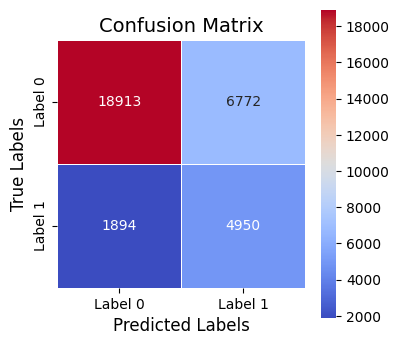

In [6]:


# Klassifikationsbericht erstellen
report = classification_report(y_test_data_2, predicted_classes_21_tok, target_names=["Class 0", "Class 1"])
print("Classification Report:\n", report)

cm = confusion_matrix(y_test_data_2, predicted_classes_21_tok)
print(cm)
# Verwirrungsmatrix visualisieren
plt.figure(figsize=(4, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="coolwarm", linewidths=0.5, square=True,
            xticklabels=["Label 0", "Label 1"], yticklabels=["Label 0", "Label 1"])
plt.xlabel("Predicted Labels", fontsize=12)
plt.ylabel("True Labels", fontsize=12)
plt.title("Confusion Matrix", fontsize=14)
plt.show()

Model_21 predicten Testdaten

In [1]:

source_filepath_name = os.path.abspath(os.path.join(src_path, 'data/mixed_dataset/test.csv'))

df_test = pd.read_csv(source_filepath_name, encoding='utf-8', index_col=0)

X_test_data_vectors_3 , text_col_test_data, glove_embeddings_3_test,tokenizer_3_test = vectorize_glove_test_data_3(df=df_test, text_column ="tweet_cleaned", glove_path=twitter_glove_path, tokenizer=tokenizer_2)


NameError: name 'os' is not defined

In [ ]:
predictions_21_test= model_21_tok.predict(X_test_data_vectors_3)
threshold=0.35 # Oder teste 0.4 oder 0.6
predicted_classes_21_test = (predictions_21_test > threshold).astype(int)

Model_21 auf testdaten predicten

Model_21 mit anderem Tokenizer und glove funktion

In [8]:
print(type(y_train))
print(y_train.keys() if isinstance(y_train, dict) else "Not a dict")


<class 'dict'>
dict_keys(['the', ',', '.', 'of', 'to', 'and', 'in', 'a', '"', "'s", 'for', '-', 'that', 'on', 'is', 'was', 'said', 'with', 'he', 'as', 'it', 'by', 'at', '(', ')', 'from', 'his', "''", '``', 'an', 'be', 'has', 'are', 'have', 'but', 'were', 'not', 'this', 'who', 'they', 'had', 'i', 'which', 'will', 'their', ':', 'or', 'its', 'one', 'after', 'new', 'been', 'also', 'we', 'would', 'two', 'more', "'", 'first', 'about', 'up', 'when', 'year', 'there', 'all', '--', 'out', 'she', 'other', 'people', "n't", 'her', 'percent', 'than', 'over', 'into', 'last', 'some', 'government', 'time', '$', 'you', 'years', 'if', 'no', 'world', 'can', 'three', 'do', ';', 'president', 'only', 'state', 'million', 'could', 'us', 'most', '_', 'against', 'u.s.', 'so', 'them', 'what', 'him', 'united', 'during', 'before', 'may', 'since', 'many', 'while', 'where', 'states', 'because', 'now', 'city', 'made', 'like', 'between', 'did', 'just', 'national', 'day', 'country', 'under', 'such', 'second', 'then', 'c

In [7]:
print(f"X_train_vectors Shape: {X_train_vectors.shape}")
print(f"y_train Shape: {y_train.shape}")
print(f"X_test_vectors Shape: {X_test_vectors.shape}")
print(f"y_test Shape: {y_test.shape}")


X_train_vectors Shape: (83305, 50, 200)


AttributeError: 'dict' object has no attribute 'shape'

In [ ]:

# X_train_vectors, X_test_vectors, y_train, y_test, glove_embeddings, tokenizer = vectorize_glove_new(
#     df=df_cleaned, text_column="tweet_cleaned", label_column="label", glove_path=twitter_glove_path
# )

# X_test_data_vectors, y_test_data, glove_embeddings_test, tokenizer_test, _, _ = vectorize_glove_new(
#     df=df_cleaned_test, text_column="tweet_cleaned", label_column="label",
#     glove_path=twitter_glove_path, tokenizer=tokenizer  # Nutzt den bereits gelernten Tokenizer!
# )


samples, max_seq_len, vector_size = X_train_vectors.shape
num_classes = len(np.unique(y_train))
# Modellinitialisierung
model_21 = Sequential()

# LSTM-Schicht
model_21.add(LSTM(units=128, input_shape=(max_seq_len, vector_size), return_sequences=False))

# Optional: Dropout zur Vermeidung von Overfitting
model_21.add(Dropout(0.5))

# Dense-Schicht für die Ausgabe
model_21.add(Dense(units=1, activation='sigmoid'))

# Kompilieren des Modells mit verbesserter Lernrate
model_21.compile(optimizer=Adam(),
                 loss='binary_crossentropy',
                 metrics=['accuracy', Recall()])

#class_weight = {0: 1, 1: 3}
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=0.00001)

history_21 = model_21.fit(
    X_train_vectors, np.array(y_train),
    validation_data=(X_test_vectors, np.array(y_test)),
    epochs=50,
    batch_size=32,
    callbacks=[early_stopping,reduce_lr],
    #class_weight=class_weight,
    verbose=2
)

# Vorhersagen auf Testdaten
predictions_21= model_21.predict(X_test_data_vectors)
threshold = 0.5  # Oder teste 0.4 oder 0.6
# threshold=0.35
predicted_classes_21 = (predictions_21 > threshold).astype(int)







C:\Users\Nasiba\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


IndexError: tuple index out of range

In [7]:
# Vorhersagen auf Testdaten
predictions_21_tok_3= model_21_tok_3.predict(X_test_data_vectors_3)
threshold = 0.5  # Oder teste 0.4 oder 0.6
predicted_classes_21_tok_3 = (predictions_21_tok_3 > threshold).astype(int)

1017/1017 ━━━━━━━━━━━━━━━━━━━━ 14s 13ms/step


Classification Report:
               precision    recall  f1-score   support

     Class 0       0.90      0.82      0.86     25685
     Class 1       0.50      0.65      0.56      6844

    accuracy                           0.79     32529
   macro avg       0.70      0.74      0.71     32529
weighted avg       0.81      0.79      0.80     32529

[[21190  4495]
 [ 2417  4427]]


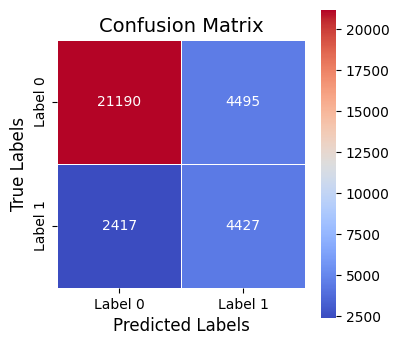

In [8]:


# Klassifikationsbericht erstellen
report = classification_report(y_test_data_3, predicted_classes_21_tok_3, target_names=["Class 0", "Class 1"])
print("Classification Report:\n", report)

cm = confusion_matrix(y_test_data_3, predicted_classes_21_tok_3)
print(cm)
# Verwirrungsmatrix visualisieren
plt.figure(figsize=(4, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="coolwarm", linewidths=0.5, square=True,
            xticklabels=["Label 0", "Label 1"], yticklabels=["Label 0", "Label 1"])
plt.xlabel("Predicted Labels", fontsize=12)
plt.ylabel("True Labels", fontsize=12)
plt.title("Confusion Matrix", fontsize=14)
plt.show()

Model_21 mit fastttext

In [8]:
samples, vector_size = X_train_vectors_fast.shape 
num_classes = len(np.unique(y_train_fast))
# Modellinitialisierung
num_classes

2

In [11]:

samples, vector_size = X_train_vectors_fast.shape 
num_classes = len(np.unique(y_train_fast))
# Modellinitialisierung
model_21_tok_fast = Sequential()

# LSTM-Schicht
model_21_tok_fast.add(Dense(128, input_shape=(vector_size,), activation='relu'))


# Optional: Dropout zur Vermeidung von Overfitting
model_21_tok_fast.add(Dropout(0.5))

# Dense-Schicht für die Ausgabe
model_21_tok_fast.add(Dense(units=1, activation='sigmoid'))

# Kompilieren des Modells mit verbesserter Lernrate
model_21_tok_fast.compile(optimizer=Adam(),
                 loss='binary_crossentropy',
                 metrics=['accuracy', Recall()])

class_weight = {0: 1, 1: 3}
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=0.00001)

history_21_tok_fast = model_21_tok_fast.fit(
    X_train_vectors_fast, np.array(y_train_fast),
    validation_data=(X_test_vectors_fast, np.array(y_test_fast)),
    epochs=50,
    batch_size=32,
    callbacks=[early_stopping,reduce_lr],
    class_weight=class_weight,
    verbose=2
)

# Vorhersagen auf Testdaten
predictions_21_tok_fast= model_21_tok_fast.predict(X_test_data_vectors_test_fast)
threshold = 0.5  # Oder teste 0.4 oder 0.6
predicted_classes_21_tok_fast = (predictions_21_tok_fast > threshold).astype(int)





C:\Users\Nasiba\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
1823/1823 - 8s - 4ms/step - accuracy: 0.8194 - loss: 0.9125 - recall: 0.0039 - val_accuracy: 0.8175 - val_loss: 0.6558 - val_recall: 0.0000e+00 - learning_rate: 0.0010
Epoch 2/50
1823/1823 - 4s - 2ms/step - accuracy: 0.8220 - loss: 0.9100 - recall: 0.0000e+00 - val_accuracy: 0.8175 - val_loss: 0.6178 - val_recall: 0.0000e+00 - learning_rate: 0.0010
Epoch 3/50
1823/1823 - 4s - 2ms/step - accuracy: 0.8220 - loss: 0.9082 - recall: 0.0000e+00 - val_accuracy: 0.8175 - val_loss: 0.5995 - val_recall: 0.0000e+00 - learning_rate: 0.0010
Epoch 4/50
1823/1823 - 4s - 2ms/step - accuracy: 0.8220 - loss: 0.9061 - recall: 0.0000e+00 - val_accuracy: 0.8175 - val_loss: 0.5935 - val_recall: 0.0000e+00 - learning_rate: 0.0010
Epoch 5/50
1823/1823 - 4s - 2ms/step - accuracy: 0.8220 - loss: 0.9045 - recall: 0.0000e+00 - val_accuracy: 0.8175 - val_loss: 0.5895 - val_recall: 0.0000e+00 - learning_rate: 0.0010
Epoch 6/50
1823/1823 - 4s - 2ms/step - accuracy: 0.8220 - loss: 0.8986 - recall: 0.0000e+

C:\Users\Nasiba\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Nasiba\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Nasiba\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classific

Classification Report:
               precision    recall  f1-score   support

     Class 0       0.79      1.00      0.88     25685
     Class 1       0.00      0.00      0.00      6844

    accuracy                           0.79     32529
   macro avg       0.39      0.50      0.44     32529
weighted avg       0.62      0.79      0.70     32529

[[25685     0]
 [ 6844     0]]


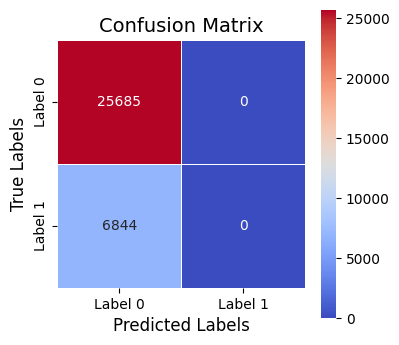

In [12]:


# Klassifikationsbericht erstellen
report = classification_report(y_test_data_test_fast, predicted_classes_21_tok_fast, target_names=["Class 0", "Class 1"])
print("Classification Report:\n", report)

cm = confusion_matrix(y_test_data_test_fast, predicted_classes_21_tok_fast)
print(cm)
# Verwirrungsmatrix visualisieren
plt.figure(figsize=(4, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="coolwarm", linewidths=0.5, square=True,
            xticklabels=["Label 0", "Label 1"], yticklabels=["Label 0", "Label 1"])
plt.xlabel("Predicted Labels", fontsize=12)
plt.ylabel("True Labels", fontsize=12)
plt.title("Confusion Matrix", fontsize=14)
plt.show()

Dropout reduziering + threshold reduzierung

In [ ]:

samples, max_seq_len, vector_size = X_train_vectors.shape
num_classes = len(np.unique(y_train))
# Modellinitialisierung
model_23 = Sequential()

# LSTM-Schicht
model_23.add(LSTM(units=128, input_shape=(max_seq_len, vector_size), return_sequences=False))

# Optional: Dropout zur Vermeidung von Overfitting
model_23.add(Dropout(0.35))

# Dense-Schicht für die Ausgabe
model_23.add(Dense(units=1, activation='sigmoid'))

# Kompilieren des Modells mit verbesserter Lernrate
model_23.compile(optimizer=Adam(),
                 loss='binary_crossentropy',
                 metrics=['accuracy', Recall(),'precision'])

class_weight = {0: 1, 1: 3}
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=0.00001)

history_23 = model_23.fit(
    X_train_vectors, np.array(y_train),
    validation_data=(X_test_vectors, np.array(y_test)),
    epochs=50,
    batch_size=32,
    callbacks=[early_stopping,reduce_lr],
    class_weight=class_weight,
    verbose=2
)

# Vorhersagen auf Testdaten
predictions_23= model_23.predict(X_test_data_vectors)
threshold = 0.35  # Oder teste 0.4 oder 0.6
predicted_classes_23 = (predictions_23 > threshold).astype(int)





C:\Users\Nasiba\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
1823/1823 - 93s - 51ms/step - accuracy: 0.7642 - loss: 0.7799 - precision: 0.3780 - recall: 0.5037 - val_accuracy: 0.7571 - val_loss: 0.4781 - val_precision: 0.4059 - val_recall: 0.7143 - learning_rate: 0.0010
Epoch 2/50
1823/1823 - 71s - 39ms/step - accuracy: 0.8007 - loss: 0.6920 - precision: 0.4550 - recall: 0.6043 - val_accuracy: 0.7724 - val_loss: 0.4820 - val_precision: 0.4255 - val_recall: 0.7061 - learning_rate: 0.0010
Epoch 3/50
1823/1823 - 75s - 41ms/step - accuracy: 0.8109 - loss: 0.6551 - precision: 0.4764 - recall: 0.6306 - val_accuracy: 0.7814 - val_loss: 0.4559 - val_precision: 0.4382 - val_recall: 0.7026 - learning_rate: 0.0010
Epoch 4/50
1823/1823 - 73s - 40ms/step - accuracy: 0.8185 - loss: 0.6232 - precision: 0.4927 - recall: 0.6621 - val_accuracy: 0.8355 - val_loss: 0.4049 - val_precision: 0.5508 - val_recall: 0.5353 - learning_rate: 0.0010
Epoch 5/50
1823/1823 - 75s - 41ms/step - accuracy: 0.8283 - loss: 0.5866 - precision: 0.5131 - recall: 0.6869 - val_

Classification Report:
               precision    recall  f1-score   support

     Class 0       0.92      0.71      0.80     25685
     Class 1       0.41      0.76      0.53      6844

    accuracy                           0.72     32529
   macro avg       0.66      0.73      0.67     32529
weighted avg       0.81      0.72      0.74     32529

[[18265  7420]
 [ 1655  5189]]


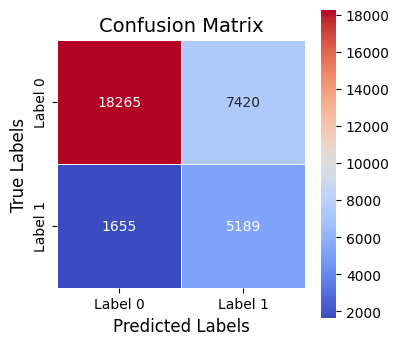

In [6]:


# Klassifikationsbericht erstellen
report = classification_report(y_test_data, predicted_classes_23, target_names=["Class 0", "Class 1"])
print("Classification Report:\n", report)

cm = confusion_matrix(y_test_data, predicted_classes_23)
print(cm)
# Verwirrungsmatrix visualisieren
plt.figure(figsize=(4, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="coolwarm", linewidths=0.5, square=True,
            xticklabels=["Label 0", "Label 1"], yticklabels=["Label 0", "Label 1"])
plt.xlabel("Predicted Labels", fontsize=12)
plt.ylabel("True Labels", fontsize=12)
plt.title("Confusion Matrix", fontsize=14)
plt.show()

Earlystop Aktivierung + Dropout Erhöhung + epochen erhöhung + learning rate dynamisieren + Class Weight erhöht

In [13]:
from tensorflow.keras.callbacks import ReduceLROnPlateau
samples, max_seq_len, vector_size = X_train_vectors.shape
num_classes = len(np.unique(y_train))
# Modellinitialisierung
model_18 = Sequential()

# LSTM-Schicht
model_18.add(LSTM(units=128, input_shape=(max_seq_len, vector_size), return_sequences=False))

# Optional: Dropout zur Vermeidung von Overfitting
model_18.add(Dropout(0.6))

# Dense-Schicht für die Ausgabe
model_18.add(Dense(units=1, activation='sigmoid'))

# Kompilieren des Modells mit verbesserter Lernrate
model_18.compile(optimizer=Adam(),
                 loss='binary_crossentropy',
                 metrics=['accuracy', Recall()])

class_weight = {0: 1, 1: 4}
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=0.00001)

history_18 = model_18.fit(
    X_train_vectors, np.array(y_train),
    validation_data=(X_test_vectors, np.array(y_test)),
    epochs=50,
    batch_size=32,
    callbacks=[early_stopping,reduce_lr],
    class_weight=class_weight,
    verbose=2
)

# Vorhersagen auf Testdaten
predictions_18 = model_18.predict(X_test_data_vectors)
threshold = 0.5  # Oder teste 0.4 oder 0.6
predicted_classes_18 = (predictions_18 > threshold).astype(int)





C:\Users\Nasiba\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
1823/1823 - 231s - 127ms/step - accuracy: 0.7188 - loss: 0.9578 - recall_4: 0.5126 - val_accuracy: 0.6277 - val_loss: 0.6287 - val_recall_4: 0.8443 - learning_rate: 0.0010
Epoch 2/50
1823/1823 - 199s - 109ms/step - accuracy: 0.7504 - loss: 0.8304 - recall_4: 0.6852 - val_accuracy: 0.7736 - val_loss: 0.4946 - val_recall_4: 0.6825 - learning_rate: 0.0010
Epoch 3/50
1823/1823 - 193s - 106ms/step - accuracy: 0.7616 - loss: 0.7871 - recall_4: 0.7084 - val_accuracy: 0.7238 - val_loss: 0.5215 - val_recall_4: 0.7783 - learning_rate: 0.0010
Epoch 4/50
1823/1823 - 223s - 122ms/step - accuracy: 0.7769 - loss: 0.7437 - recall_4: 0.7287 - val_accuracy: 0.8112 - val_loss: 0.4327 - val_recall_4: 0.6298 - learning_rate: 0.0010
Epoch 5/50
1823/1823 - 177s - 97ms/step - accuracy: 0.7908 - loss: 0.7093 - recall_4: 0.7536 - val_accuracy: 0.8128 - val_loss: 0.4200 - val_recall_4: 0.6263 - learning_rate: 0.0010
Epoch 6/50
1823/1823 - 115s - 63ms/step - accuracy: 0.8075 - loss: 0.6641 - recall_4: 

Classification Report:
               precision    recall  f1-score   support

     Class 0       0.90      0.83      0.86     25685
     Class 1       0.50      0.65      0.56      6844

    accuracy                           0.79     32529
   macro avg       0.70      0.74      0.71     32529
weighted avg       0.81      0.79      0.80     32529

[[21207  4478]
 [ 2426  4418]]


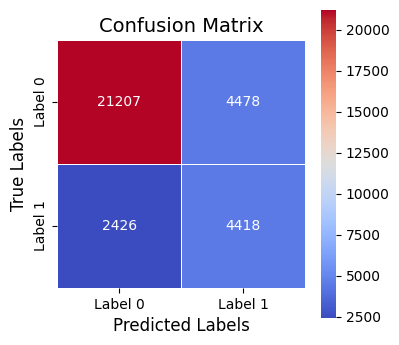

In [14]:


# Klassifikationsbericht erstellen
report = classification_report(y_test_data, predicted_classes_18, target_names=["Class 0", "Class 1"])
print("Classification Report:\n", report)

cm = confusion_matrix(y_test_data, predicted_classes_18)
print(cm)
# Verwirrungsmatrix visualisieren
plt.figure(figsize=(4, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="coolwarm", linewidths=0.5, square=True,
            xticklabels=["Label 0", "Label 1"], yticklabels=["Label 0", "Label 1"])
plt.xlabel("Predicted Labels", fontsize=12)
plt.ylabel("True Labels", fontsize=12)
plt.title("Confusion Matrix", fontsize=14)
plt.show()

Earlystop Aktivierung + Dropout Erhöhung + epochen erhöhung + learning rate dynamisieren + Class Weight erhöht + niedrigerer Threshold + shuffle aktiviert

In [5]:
from tensorflow.keras.callbacks import ReduceLROnPlateau
samples, max_seq_len, vector_size = X_train_vectors.shape
num_classes = len(np.unique(y_train))
# Modellinitialisierung
model_20 = Sequential()

# LSTM-Schicht
model_20.add(LSTM(units=128, input_shape=(max_seq_len, vector_size), return_sequences=False))

# Optional: Dropout zur Vermeidung von Overfitting
model_20.add(Dropout(0.6))

# Dense-Schicht für die Ausgabe
model_20.add(Dense(units=1, activation='sigmoid'))

# Kompilieren des Modells mit verbesserter Lernrate
model_20.compile(optimizer=Adam(),
                 loss='binary_crossentropy',
                 metrics=['accuracy', Recall()])

class_weight = {0: 1, 1: 3}
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=0.00001)

history_20 = model_20.fit(
    X_train_vectors, np.array(y_train),
    validation_data=(X_test_vectors, np.array(y_test)),
    epochs=50,
    batch_size=32,
    shuffle=True, 
    callbacks=[early_stopping,reduce_lr],
    class_weight=class_weight,
    verbose=2
)

# Vorhersagen auf Testdaten
predictions_20 = model_20.predict(X_test_data_vectors)
threshold = 0.4  # Oder teste 0.4 oder 0.6
predicted_classes_20 = (predictions_20 > threshold).astype(int)





C:\Users\Nasiba\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
1823/1823 - 102s - 56ms/step - accuracy: 0.7681 - loss: 0.7894 - recall: 0.4958 - val_accuracy: 0.8024 - val_loss: 0.4549 - val_recall: 0.5919 - learning_rate: 0.0010
Epoch 2/50
1823/1823 - 91s - 50ms/step - accuracy: 0.8026 - loss: 0.6988 - recall: 0.5864 - val_accuracy: 0.8382 - val_loss: 0.3781 - val_recall: 0.4342 - learning_rate: 0.0010
Epoch 3/50
1823/1823 - 90s - 50ms/step - accuracy: 0.8099 - loss: 0.6623 - recall: 0.6221 - val_accuracy: 0.8244 - val_loss: 0.4023 - val_recall: 0.5827 - learning_rate: 0.0010
Epoch 4/50
1823/1823 - 87s - 48ms/step - accuracy: 0.8203 - loss: 0.6325 - recall: 0.6305 - val_accuracy: 0.7716 - val_loss: 0.4717 - val_recall: 0.7279 - learning_rate: 0.0010
Epoch 5/50
1823/1823 - 92s - 50ms/step - accuracy: 0.8237 - loss: 0.5996 - recall: 0.6830 - val_accuracy: 0.7592 - val_loss: 0.4428 - val_recall: 0.7568 - learning_rate: 0.0010
Epoch 6/50
1823/1823 - 86s - 47ms/step - accuracy: 0.8379 - loss: 0.5401 - recall: 0.7317 - val_accuracy: 0.8174 -

In [6]:
# Vorhersagen auf Testdaten
predictions_20_1= model_20.predict(X_test_data_vectors)
threshold = 0.5  # Oder teste 0.4 oder 0.6
predicted_classes_20_1 = (predictions_20_1 > threshold).astype(int)

1017/1017 ━━━━━━━━━━━━━━━━━━━━ 19s 19ms/step


Classification Report:
               precision    recall  f1-score   support

     Class 0       0.89      0.82      0.85     25685
     Class 1       0.48      0.63      0.54      6844

    accuracy                           0.78     32529
   macro avg       0.68      0.72      0.70     32529
weighted avg       0.80      0.78      0.79     32529

[[20951  4734]
 [ 2531  4313]]


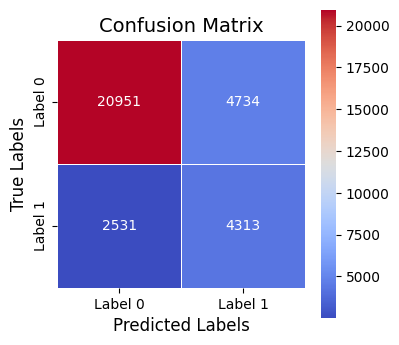

In [8]:

# Klassifikationsbericht erstellen
report = classification_report(y_test_data, predicted_classes_20, target_names=["Class 0", "Class 1"])
print("Classification Report:\n", report)

cm = confusion_matrix(y_test_data, predicted_classes_20)
print(cm)
# Verwirrungsmatrix visualisieren
plt.figure(figsize=(4, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="coolwarm", linewidths=0.5, square=True,
            xticklabels=["Label 0", "Label 1"], yticklabels=["Label 0", "Label 1"])
plt.xlabel("Predicted Labels", fontsize=12)
plt.ylabel("True Labels", fontsize=12)
plt.title("Confusion Matrix", fontsize=14)
plt.show()

Classification Report:
               precision    recall  f1-score   support

     Class 0       0.86      0.91      0.89     25685
     Class 1       0.59      0.46      0.52      6844

    accuracy                           0.82     32529
   macro avg       0.73      0.69      0.70     32529
weighted avg       0.81      0.82      0.81     32529

[[23444  2241]
 [ 3673  3171]]


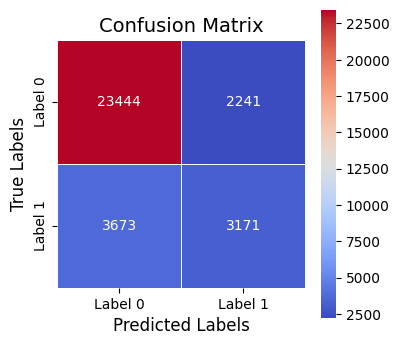

In [9]:



# Klassifikationsbericht erstellen
report = classification_report(y_test_data, predicted_classes_20_1, target_names=["Class 0", "Class 1"])
print("Classification Report:\n", report)

cm = confusion_matrix(y_test_data, predicted_classes_20_1)
print(cm)
# Verwirrungsmatrix visualisieren
plt.figure(figsize=(4, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="coolwarm", linewidths=0.5, square=True,
            xticklabels=["Label 0", "Label 1"], yticklabels=["Label 0", "Label 1"])
plt.xlabel("Predicted Labels", fontsize=12)
plt.ylabel("True Labels", fontsize=12)
plt.title("Confusion Matrix", fontsize=14)
plt.show()

CNN + LSTM

In [15]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, LSTM, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam

# Modellinitialisierung
model_cnn_lstm = Sequential()

# 1D Convolutional Layer (Extrahiert lokale Wortmuster)
model_cnn_lstm.add(Conv1D(filters=128, kernel_size=5, activation='relu', input_shape=(max_seq_len, vector_size)))
model_cnn_lstm.add(MaxPooling1D(pool_size=2))  # Reduziert die Dimension und extrahiert wichtigste Merkmale

# LSTM Layer (Lernt Sequenzinformationen)
model_cnn_lstm.add(LSTM(units=128, return_sequences=False))

# Dropout für Regularisierung
model_cnn_lstm.add(Dropout(0.5))

# Dense Output Layer
model_cnn_lstm.add(Dense(1, activation='sigmoid'))  # Binary Classification

# Kompilieren des Modells
model_cnn_lstm.compile(optimizer=Adam(learning_rate=0.0005),
                        loss='binary_crossentropy',
                        metrics=['accuracy', Recall()])

# Training
history_cnn_lstm = model_cnn_lstm.fit(
    X_train_vectors, np.array(y_train),
    validation_data=(X_test_vectors, np.array(y_test)),
    epochs=30,
    batch_size=32,
    verbose=2
)
# Vorhersagen auf Testdaten
predictions_cnn_lstm= model_cnn_lstm.predict(X_test_data_vectors)
threshold = 0.5  # Oder teste 0.4 oder 0.6
predicted_classes_cnn_lstm= (predictions_cnn_lstm > threshold).astype(int)

C:\Users\Nasiba\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
1822/1822 - 66s - 36ms/step - accuracy: 0.8318 - loss: 0.4001 - val_accuracy: 0.8416 - val_loss: 0.3710
Epoch 2/30
1822/1822 - 54s - 29ms/step - accuracy: 0.8512 - loss: 0.3498 - val_accuracy: 0.8497 - val_loss: 0.3597
Epoch 3/30
1822/1822 - 55s - 30ms/step - accuracy: 0.8645 - loss: 0.3165 - val_accuracy: 0.8434 - val_loss: 0.3648
Epoch 4/30
1822/1822 - 60s - 33ms/step - accuracy: 0.8818 - loss: 0.2762 - val_accuracy: 0.8472 - val_loss: 0.3672
Epoch 5/30
1822/1822 - 59s - 32ms/step - accuracy: 0.9035 - loss: 0.2333 - val_accuracy: 0.8416 - val_loss: 0.4434
Epoch 6/30
1822/1822 - 58s - 32ms/step - accuracy: 0.9214 - loss: 0.1920 - val_accuracy: 0.8332 - val_loss: 0.4433
Epoch 7/30
1822/1822 - 54s - 30ms/step - accuracy: 0.9356 - loss: 0.1608 - val_accuracy: 0.8169 - val_loss: 0.5091
Epoch 8/30
1822/1822 - 54s - 30ms/step - accuracy: 0.9479 - loss: 0.1334 - val_accuracy: 0.8392 - val_loss: 0.5726
Epoch 9/30
1822/1822 - 60s - 33ms/step - accuracy: 0.9567 - loss: 0.1131 - val_a

Classification Report:
               precision    recall  f1-score   support

     Class 0       0.87      0.87      0.87     25685
     Class 1       0.51      0.51      0.51      6844

    accuracy                           0.79     32529
   macro avg       0.69      0.69      0.69     32529
weighted avg       0.79      0.79      0.79     32529

[[22321  3364]
 [ 3337  3507]]


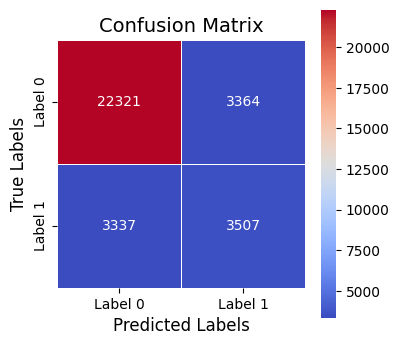

In [16]:


# Klassifikationsbericht erstellen
report = classification_report(y_test_data, predicted_classes_cnn_lstm, target_names=["Class 0", "Class 1"])
print("Classification Report:\n", report)

cm = confusion_matrix(y_test_data, predicted_classes_cnn_lstm)
print(cm)
# Verwirrungsmatrix visualisieren
plt.figure(figsize=(4, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="coolwarm", linewidths=0.5, square=True,
            xticklabels=["Label 0", "Label 1"], yticklabels=["Label 0", "Label 1"])
plt.xlabel("Predicted Labels", fontsize=12)
plt.ylabel("True Labels", fontsize=12)
plt.title("Confusion Matrix", fontsize=14)
plt.show()

BERNT+LSTM

In [17]:
text_column = "tweet_cleaned"  # Name der Spalte mit den Tweets
label_column = "label"         # Name der Spalte mit den Labels

# Entferne fehlende Werte (falls vorhanden)


# 1️⃣ Daten in Features (X) und Labels (y) trennen
X = df_cleaned[text_column].astype(str).tolist()  # Konvertiere Tweets in eine Liste
y = df_cleaned[label_column].values  # Labels extrahieren

X_test_data_bert = df_cleaned_test[text_column].astype(str).tolist()  # Konvertiere Tweets in eine Liste
y_test_data_bert = df_cleaned_test[label_column].values  # Labels extrahieren

# 2️⃣ Daten in Trainings- und Testsets aufteilen (80% Train, 20% Test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_train

['she say she be not trick off on they hoesllsfoolish',
 'I be guess the person who say they just want to film someone attack they be their goal so they could use the video to make pro - immigration people seem violent',
 'straight couple have love and commitment in their relationship',
 'denmark trade balance rise from previous b to b in april blog silver gold forex',
 'be change family lawyer on how food be integral to family bond nomnom foodporn food blog',
 'I want sheri   emilie to have their own show with special appearance from annie   lloyd mkr',
 'karen armstrong kiss the criminal mohammed ass so that she can sell book',
 'this nigga say   " throw a pad at I   call I a cramp because I be not play with you hoe period " face with tear of joy face with tear of joy face with tear of joy',
 'lot of other country grant citizenship base on birth url althugh only an american would not look into other country beyond canada',
 'hr and min leave face scream in fear face scream in fear kc

In [22]:
import tensorflow as tf
import numpy as np
import transformers
from transformers import BertTokenizer, TFBertModel
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

text_column = "tweet_cleaned"  # Name der Spalte mit den Tweets
label_column = "label"         # Name der Spalte mit den Labels

# Entferne fehlende Werte (falls vorhanden)


# 1️⃣ Daten in Features (X) und Labels (y) trennen
X = df_cleaned[text_column].astype(str).tolist()  # Konvertiere Tweets in eine Liste
y = df_cleaned[label_column].values  # Labels extrahieren

# 2️⃣ Daten in Trainings- und Testsets aufteilen (80% Train, 20% Test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# 1️⃣ Lade den BERT Tokenizer und das vortrainierte Modell
bert_model_name = "bert-base-uncased"  # Oder 'bert-base-multilingual-cased' für mehrsprachige Modelle
tokenizer = BertTokenizer.from_pretrained(bert_model_name)
bert_model = TFBertModel.from_pretrained(bert_model_name)

# 2️⃣ Funktion zur Tokenisierung der Tweets mit BERT
def tokenize_texts(texts, max_length=50):
    return tokenizer(texts, padding=True, truncation=True, max_length=max_length, return_tensors="tf")

# 3️⃣ Feature-Extraktion mit BERT (nutzt [CLS]-Token als Repräsentation)
def extract_bert_features(texts, max_length=50):
    inputs = tokenize_texts(texts, max_length)
    outputs = bert_model(inputs["input_ids"], attention_mask=inputs["attention_mask"])
    return outputs.last_hidden_state[:, 0, :].numpy()  # CLS-Token als Feature-Vektor

# 4️⃣ Konvertiere die Texte in BERT-Features
X_train_bert = extract_bert_features(X_train.tolist())  # Train-Daten in Vektoren umwandeln
X_test_bert = extract_bert_features(X_test.tolist())  # Test-Daten umwandeln

# 5️⃣ Definiere das LSTM-Modell
model_bert_lstm = Sequential([
    LSTM(128, input_shape=(X_train_bert.shape[1],), return_sequences=False),  # LSTM mit 128 Einheiten
    Dropout(0.5),  # Vermeidung von Overfitting
    Dense(1, activation='sigmoid')  # Sigmoid-Aktivierung für Binärklassifikation
])

# 6️⃣ Kompiliere das Modell
model_bert_lstm.compile(
    optimizer=Adam(learning_rate=2e-5),  # Lernrate für fein abgestimmtes Training
    loss='binary_crossentropy',
    metrics=['accuracy', Recall()]
)

# 7️⃣ Training mit EarlyStopping, um Overfitting zu verhindern
early_stopping = EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True)

history_bert_lstm = model_bert_lstm.fit(
    X_train_bert, np.array(y_train),
    validation_data=(X_test_bert, np.array(y_test)),
    epochs=10, batch_size=32,
    callbacks=[early_stopping],
    verbose=1
)

# 8️⃣ Predictions und Schwellenwert-Anpassung
predictions_bert_lstm = model_bert_lstm.predict(X_test_data_bert)
threshold = 0.5  # Optional anpassbar (z. B. 0.4 oder 0.6)
predicted_classes_bert_lstm = (predictions_bert_lstm > threshold).astype(int)




tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

C:\Users\Nasiba\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\huggingface_hub\file_download.py:140: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Nasiba\.cache\huggingface\hub\models--bert-base-uncased. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Error while downloading from https://cdn-lfs.hf.co/bert-base-uncased/68d45e234eb4a928074dfd868cead0219ab85354cc53d20e772753c6bb9169d3?response-content-disposition=inline%3B+filename*%3DUTF-8%27%27model.safetensors%3B+filename%3D%22model.safetensors%22%3B&Expires=1739368087&Policy=eyJTdGF0ZW1lbnQiOlt7IkNvbmRpdGlvbiI6eyJEYXRlTGVzc1RoYW4iOnsiQVdTOkVwb2NoVGltZSI6MTczOTM2ODA4N319LCJSZXNvdXJjZSI6Imh0dHBzOi8vY2RuLWxmcy5oZi5jby9iZXJ0LWJhc2UtdW5jYXNlZC82OGQ0NWUyMzRlYjRhOTI4MDc0ZGZkODY4Y2VhZDAyMTlhYjg1MzU0Y2M1M2QyMGU3NzI3NTNjNmJiOTE2OWQzP3Jlc3BvbnNlLWNvbnRlbnQtZGlzcG9zaXRpb249KiJ9XX0_&Signature=K3779UxlOx36lq3-Y9ClDQxSZPj7SNPiWkISj3ORQwRyQsEbuMJ2rRepBwWqRnSyRbO5ODu2acEScf6OGIsER7iZBm1ensQXGdjcGxsZYajNjPVWsZ2uhLC9I0pxPleWEUg8lwwTtI%7EtWglbr%7EYDgHjfy3tgXv2BAKETcHXMRSXxuNujXZkKQSa6Tc8bNoDNNrCja1WJFuPwtgrGqOBKI1SkQo6a92NOe9I7MINmXlFvgm2aqLyl-5FWHuO-v8zgk1s2-fIEGkYrKLGZKRzF6pWRcoEuIr5tDP-NkSIBvuUYPY38gV4vPH9QaoT-RA5NDDGpNKAQSMzMpK7eVnUsxA__&Key-Pair-Id=K3RPWS32NSSJCE: HTTPSConnectionPool(host='cdn-l

SSLError: (MaxRetryError("HTTPSConnectionPool(host='cdn-lfs.hf.co', port=443): Max retries exceeded with url: /bert-base-uncased/68d45e234eb4a928074dfd868cead0219ab85354cc53d20e772753c6bb9169d3?response-content-disposition=inline%3B+filename*%3DUTF-8%27%27model.safetensors%3B+filename%3D%22model.safetensors%22%3B&Expires=1739368087&Policy=eyJTdGF0ZW1lbnQiOlt7IkNvbmRpdGlvbiI6eyJEYXRlTGVzc1RoYW4iOnsiQVdTOkVwb2NoVGltZSI6MTczOTM2ODA4N319LCJSZXNvdXJjZSI6Imh0dHBzOi8vY2RuLWxmcy5oZi5jby9iZXJ0LWJhc2UtdW5jYXNlZC82OGQ0NWUyMzRlYjRhOTI4MDc0ZGZkODY4Y2VhZDAyMTlhYjg1MzU0Y2M1M2QyMGU3NzI3NTNjNmJiOTE2OWQzP3Jlc3BvbnNlLWNvbnRlbnQtZGlzcG9zaXRpb249KiJ9XX0_&Signature=K3779UxlOx36lq3-Y9ClDQxSZPj7SNPiWkISj3ORQwRyQsEbuMJ2rRepBwWqRnSyRbO5ODu2acEScf6OGIsER7iZBm1ensQXGdjcGxsZYajNjPVWsZ2uhLC9I0pxPleWEUg8lwwTtI~tWglbr~YDgHjfy3tgXv2BAKETcHXMRSXxuNujXZkKQSa6Tc8bNoDNNrCja1WJFuPwtgrGqOBKI1SkQo6a92NOe9I7MINmXlFvgm2aqLyl-5FWHuO-v8zgk1s2-fIEGkYrKLGZKRzF6pWRcoEuIr5tDP-NkSIBvuUYPY38gV4vPH9QaoT-RA5NDDGpNKAQSMzMpK7eVnUsxA__&Key-Pair-Id=K3RPWS32NSSJCE (Caused by SSLError(SSLError(1, '[SSL: WRONG_VERSION_NUMBER] wrong version number (_ssl.c:1006)')))"), '(Request ID: 666f9b90-7324-4c7a-95c2-d5af1820d5b9)')

In [ ]:


# Klassifikationsbericht erstellen
report = classification_report(y_test_data_bert, predicted_classes_bert_lstm, target_names=["Class 0", "Class 1"])
print("Classification Report:\n", report)

cm = confusion_matrix(y_test_data_bert, predicted_classes_bert_lstm)
print(cm)
# Verwirrungsmatrix visualisieren
plt.figure(figsize=(4, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="coolwarm", linewidths=0.5, square=True,
            xticklabels=["Label 0", "Label 1"], yticklabels=["Label 0", "Label 1"])
plt.xlabel("Predicted Labels", fontsize=12)
plt.ylabel("True Labels", fontsize=12)
plt.title("Confusion Matrix", fontsize=14)
plt.show()

Epochenreduzierung: funktioniert nicht gut, da er zu wenig lernt

Bidirektional

2 LSTM Schichten und Batch-Normalisierung

In [27]:
samples, max_seq_len, vector_size = X_train_vectors.shape
num_classes = len(np.unique(y_train))
samples


58289

In [30]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

samples, max_seq_len, vector_size = X_train_vectors.shape
num_classes = len(np.unique(y_train))
# Klassenbalancierung berechnen
#class_weight = {0: 1, 1: 3}  # Manuell festgelegt, kann auch dynamisch berechnet werden

# Modellinitialisierung
model_new_1 = Sequential()

# Erste LSTM-Schicht mit Rückgabe von Sequenzen
model_new_1.add(LSTM(units=128, return_sequences=True, input_shape=(max_seq_len, vector_size)))
model_new_1.add(BatchNormalization())  # Batch-Normalisierung

# Zweite LSTM-Schicht
model_new_1.add(LSTM(units=64, return_sequences=False))
model_new_1.add(Dropout(0.5))  # Dropout zur Regularisierung

# Dense-Schicht mit Sigmoid für binäre Klassifikation
model_new_1.add(Dense(1, activation='sigmoid'))

# Kompilieren des Modells
model_new_1.compile(optimizer=Adam(learning_rate=0.001),
                    loss='binary_crossentropy',
                    metrics=['accuracy',Recall()])

# Frühes Stoppen aktivieren
# early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
class_weight = {0: 1, 1: 3}
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=0.00001)

# Training des Modells
history_new_1 = model_new_1.fit(
    X_train_vectors, np.array(y_train),
    validation_data=(X_test_vectors, np.array(y_test)),
    epochs=50,
    batch_size=32,
    class_weight=class_weight,
    callbacks=[early_stopping,reduce_lr],
    verbose=2
)
# Vorhersagen auf Testdaten
predictions_new_1 =  model_new_1.predict(X_test_data_vectors)
threshold = 0.5  # Oder teste 0.4 oder 0.6
predicted_classes__new_1 = (predictions_new_1 > threshold).astype(int)




Epoch 1/50
1822/1822 - 148s - 81ms/step - accuracy: 0.7839 - loss: 0.8931 - recall_7: 0.1731 - val_accuracy: 0.7492 - val_loss: 0.5279 - val_recall_7: 0.6374 - learning_rate: 0.0010
Epoch 2/50
1822/1822 - 139s - 76ms/step - accuracy: 0.7767 - loss: 0.7346 - recall_7: 0.6203 - val_accuracy: 0.7421 - val_loss: 0.5132 - val_recall_7: 0.7231 - learning_rate: 0.0010
Epoch 3/50
1822/1822 - 142s - 78ms/step - accuracy: 0.7954 - loss: 0.6868 - recall_7: 0.6409 - val_accuracy: 0.7931 - val_loss: 0.4430 - val_recall_7: 0.6453 - learning_rate: 0.0010
Epoch 4/50
1822/1822 - 276s - 152ms/step - accuracy: 0.8064 - loss: 0.6493 - recall_7: 0.6686 - val_accuracy: 0.8330 - val_loss: 0.3875 - val_recall_7: 0.5111 - learning_rate: 0.0010
Epoch 5/50
1822/1822 - 346s - 190ms/step - accuracy: 0.8156 - loss: 0.6185 - recall_7: 0.6946 - val_accuracy: 0.8223 - val_loss: 0.3931 - val_recall_7: 0.5867 - learning_rate: 0.0010
Epoch 6/50
1822/1822 - 280s - 154ms/step - accuracy: 0.8211 - loss: 0.5887 - recall_7: 0

Classification Report:
               precision    recall  f1-score   support

     Class 0       0.88      0.87      0.88     25685
     Class 1       0.54      0.56      0.55      6844

    accuracy                           0.81     32529
   macro avg       0.71      0.72      0.72     32529
weighted avg       0.81      0.81      0.81     32529

[[22459  3226]
 [ 2998  3846]]


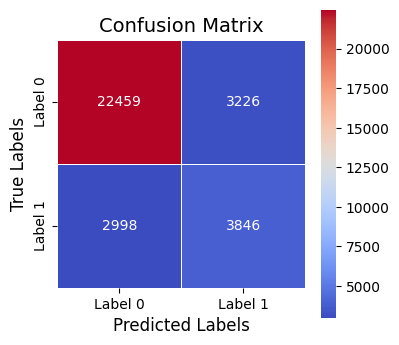

In [33]:


# Klassifikationsbericht erstellen
report = classification_report(y_test_data, predicted_classes__new_1 , target_names=["Class 0", "Class 1"])
print("Classification Report:\n", report)

cm = confusion_matrix(y_test_data, predicted_classes__new_1 )
print(cm)
# Verwirrungsmatrix visualisieren
plt.figure(figsize=(4, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="coolwarm", linewidths=0.5, square=True,
            xticklabels=["Label 0", "Label 1"], yticklabels=["Label 0", "Label 1"])
plt.xlabel("Predicted Labels", fontsize=12)
plt.ylabel("True Labels", fontsize=12)
plt.title("Confusion Matrix", fontsize=14)
plt.show()

Modell speichern

In [35]:
save_path_model = os.path.abspath(os.path.join(src_path, 'src/3. Deep Learning Approach/nasiba/model_17.keras'))
# Erstelle das Verzeichnis, falls es nicht existiert
os.makedirs(os.path.dirname(save_path_model), exist_ok=True)
#save_path_model = os.path.abspath(os.path.join(src_path, 'src/3. Deep Learning Approach/nasiba/model_17.h5')) 
model_17.save(save_path_model)
print(f"Modell wurde erfolgreich gespeichert unter: {save_path_model}")

Modell wurde erfolgreich gespeichert unter: C:\Users\Nasiba\Documents\1 Master Data Science\Projektpraktikum\WebScience24\src\3. Deep Learning Approach\nasiba\model_17.keras


In [39]:


save_path_model = os.path.abspath(os.path.join(src_path, 'src/3. Deep Learning Approach/nasiba/models/model_3.keras'))
# Erstelle das Verzeichnis, falls es nicht existiert
os.makedirs(os.path.dirname(save_path_model), exist_ok=True)
#save_path_model = os.path.abspath(os.path.join(src_path, 'src/3. Deep Learning Approach/nasiba/model_17.h5')) 
model_3.save(save_path_model)
print(f"Modell wurde erfolgreich gespeichert unter: {save_path_model}")

Modell wurde erfolgreich gespeichert unter: C:\Users\Nasiba\Documents\1 Master Data Science\Projektpraktikum\WebScience24\src\3. Deep Learning Approach\nasiba\models\model_3.keras


In [42]:



save_path_model = os.path.abspath(os.path.join(src_path, 'src/3. Deep Learning Approach/nasiba/models/model_21.keras'))
# Erstelle das Verzeichnis, falls es nicht existiert
os.makedirs(os.path.dirname(save_path_model), exist_ok=True)
#save_path_model = os.path.abspath(os.path.join(src_path, 'src/3. Deep Learning Approach/nasiba/model_17.h5')) 
model_3.save(save_path_model)
print(f"Modell wurde erfolgreich gespeichert unter: {save_path_model}")

Modell wurde erfolgreich gespeichert unter: C:\Users\Nasiba\Documents\1 Master Data Science\Projektpraktikum\WebScience24\src\3. Deep Learning Approach\nasiba\models\model_21.keras
